In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.utils import resample,shuffle
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train=pd.read_csv("/content/drive/MyDrive/Assignments/CaseStudy1/X_train.csv")
classes=pd.read_csv('/content/y_train.csv')
test=pd.read_csv("/content/drive/MyDrive/Assignments/CaseStudy1/X_test.csv")

Title of the case study is “Help Navigate Robots” and it's a kaggle competition. It's basically a
classification problem where we need to predict the type of floor on which a robot is moving. There are
9 types of floor (9 class classification).

There was an IMU sensor mounted on the robot which collects different types of data based on
position and movement of the robot. It is time series data.
It does have a total 10 features which are as follows.

orientation_X

orientation_Y

orientation_Z

orientation_W

angular_velocity_X

angular_velocity_Y

angular_velocity_Z

linear_acceleration_X

linear_acceleration_Y

linear_acceleration_Z

There are 128 readings for each component shown above (128 readings for each feature).

Total readings in the dataset are 487680 and we have 3810 unique data points(487680/128) for training and for the test there are 488448 readings which makes 3816 data points. Performance matrix
is multiclass accuracy and the 1st prize winner has got 100% accuracy.

Dataset is slightly imbalanced, a couple of categories have very less number of points.
Talking about features there are 4 features based on orientation which represents the position of the
robot with respect to different directions. Angular velocity has 3 components which are 3 of our
features, each component represents the angular velocity of the robot in different directions
(forward-reverse, up-down,left-right).
Linear acceleration also has 3 components which represents the rate of change of velocity of the
robot in 3 different directions.
All these features create 1 sample, and 128 such samples created 1 data point.

So we have orientation,angular_velocity,linear_acceleration at given time t,t+1,t+2,.....t+127.

In [ ]:
train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


In [ ]:
# value_counts for target
classes.surface.value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

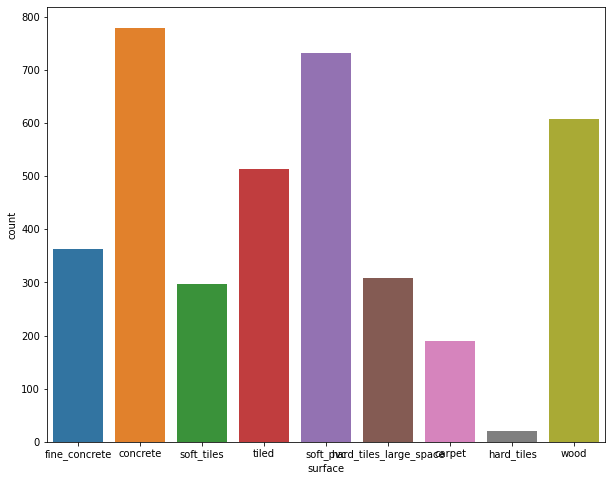

In [ ]:
""" Here we are plotting countplot for class labels to see number of classes and distribution"""

plt.figure(figsize=(10,8))
sns.countplot(x='surface',data=classes)
plt.savefig('classes.png')
plt.show()


### So as we can see, given data is imbalanced Hard_tiles has very few data points high imbalance carpet has second last position and then soft tiles

In [ ]:
test

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.187870,0.29492,2.8027,-9.6816
1,0_1,0,1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.182060,0.14944,2.5408,-9.8521
2,0_2,0,2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.184410,-0.49741,2.5853,-9.3835
3,0_3,0,3,0.91237,-0.38121,-0.050588,0.14035,-0.024217,0.037788,-0.187830,-0.32376,2.9966,-8.7415
4,0_4,0,4,0.91247,-0.38096,-0.050546,0.14042,-0.038047,0.083405,-0.201700,-0.70103,2.6498,-8.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...
488443,3815_123,3815,123,0.89516,-0.42026,-0.056425,0.13744,0.036579,0.008990,-0.008570,0.76537,3.5421,-8.4445
488444,3815_124,3815,124,0.89517,-0.42025,-0.056391,0.13742,0.022401,0.021198,-0.010905,-0.48107,3.3380,-8.8012
488445,3815_125,3815,125,0.89521,-0.42019,-0.056343,0.13734,0.033571,0.019868,-0.007203,0.44106,3.2110,-9.3700
488446,3815_126,3815,126,0.89522,-0.42019,-0.056300,0.13730,0.046988,0.015570,0.001514,-0.25947,2.8634,-9.8546


### Here train and test has same number of columns with similar information

In [ ]:
train.row_id.unique

<bound method Series.unique of 0              0_0
1              0_1
2              0_2
3              0_3
4              0_4
            ...   
487675    3809_123
487676    3809_124
487677    3809_125
487678    3809_126
487679    3809_127
Name: row_id, Length: 487680, dtype: object>

### **row_id** represents the row and subsample of that row. For example it has values strating from 
### - 0_0,0_1,0_2,0_3.......0_127 for 0th data point, and for 0th datapoint we have 128 samples
### - 1_0,1_1,1_2,1_3.......1_127 for 1st data point, and for 1st datapoint we have 128 samples
### - ....:........:..........:........:
### - ....:........:..........:........:
### - 3809_0,3809_1,3809_2,3809_3,.....,3809_127

### we can use this feature for splitting data and for mapping class labels of train set with train dataset 

### If we split row_id in two parts,first part can be used to represent diffrent datapoints or we can say sample number and second part can be used to represent subsample of diffrent datapoints or we can say a timestamp.
### This breakdown of row_id is given as two individual fiatures named **Series_id** and **measurement_number** respectively
### series_id has values ranging from 0 to 3809 and measurement number ranging from 0 to 127

In [ ]:
# merging target labels with train data using series_id feature
data=pd.merge(train,classes,on='series_id')

In [ ]:
data

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063,56,soft_pvc
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257,56,soft_pvc
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443,56,soft_pvc
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435,56,soft_pvc


### After merging, we can notice that new column has been added apart from labels which is group_id
### let's visualize group_id feature

In [ ]:
np.sort(data.group_id.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

### So as we can see group_id feature has 73 unique values 

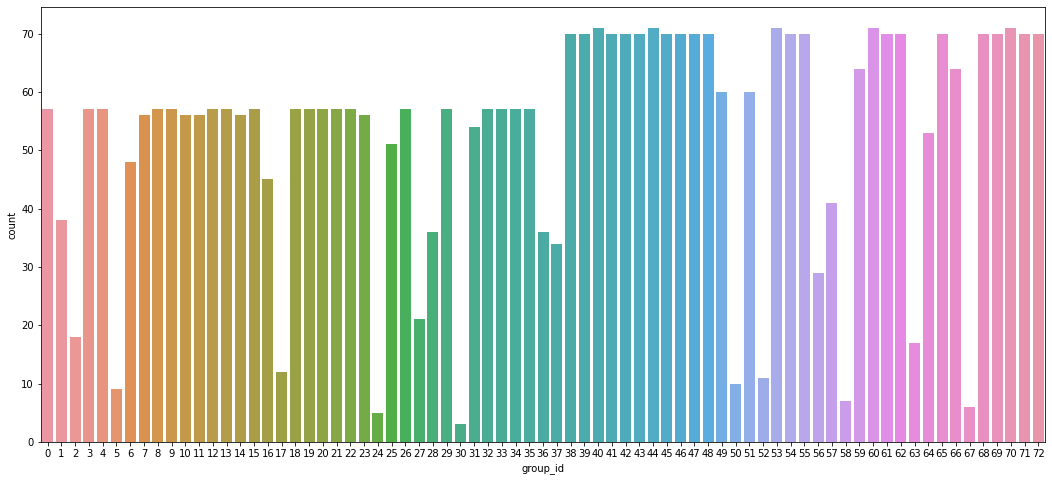

In [ ]:
# plotting countplot of group_id feature 
plt.figure(figsize=(18,8))
g = sns.countplot(classes['group_id'], order = np.sort(classes['group_id'].value_counts().index))
plt.show()    


### From above graph we can see that there are few group_Ids which occurs alot more often than some other group_Id
### For ex. id 53 occurs more than 70 times whereas Id 30 occurs less than 5 times(out of toatal 3810 datapoints)

### Lets udenserstand what does group_id mean practically with respect to our dataset and what does it represents

In [ ]:
# for group_id=1 there are 38 samples
len(classes.loc[classes.group_id==1])

38

In [ ]:
# getting unique surface types for each group_id we have
for i in range(0,73):
  sub=classes.loc[classes.group_id==i]
  print(i,sub.surface.unique())

0 ['concrete']
1 ['tiled']
2 ['wood']
3 ['soft_pvc']
4 ['soft_tiles']
5 ['concrete']
6 ['soft_pvc']
7 ['carpet']
8 ['tiled']
9 ['soft_tiles']
10 ['wood']
11 ['tiled']
12 ['concrete']
13 ['fine_concrete']
14 ['wood']
15 ['soft_tiles']
16 ['hard_tiles_large_space']
17 ['soft_tiles']
18 ['soft_pvc']
19 ['soft_pvc']
20 ['concrete']
21 ['soft_tiles']
22 ['soft_tiles']
23 ['wood']
24 ['wood']
25 ['carpet']
26 ['soft_pvc']
27 ['hard_tiles']
28 ['tiled']
29 ['soft_pvc']
30 ['fine_concrete']
31 ['concrete']
32 ['concrete']
33 ['hard_tiles_large_space']
34 ['soft_pvc']
35 ['fine_concrete']
36 ['fine_concrete']
37 ['soft_pvc']
38 ['wood']
39 ['concrete']
40 ['hard_tiles_large_space']
41 ['concrete']
42 ['concrete']
43 ['wood']
44 ['hard_tiles_large_space']
45 ['wood']
46 ['wood']
47 ['concrete']
48 ['fine_concrete']
49 ['wood']
50 ['concrete']
51 ['soft_pvc']
52 ['carpet']
53 ['soft_pvc']
54 ['tiled']
55 ['tiled']
56 ['soft_pvc']
57 ['concrete']
58 ['soft_pvc']
59 ['hard_tiles_large_space']
60 ['

### --By looking at the output of above cell we can say that each unique group_id has only one type of surface, so we can consider it as sessions.
### --There were 73 session where people who collected data went out with robot and actually collected samples

### --So each group id has one type of floor and i assuming its not just same type of floor its the exact same floor. For example lets imagine, for session 1 they went to classroom having "tiled" surface, collected few samples(38 samples with 128 timestamps each) and went back,for session 66 they went to conference room having "tiled" surface, collected few samples and went back and so on(this info is not given, these are just assumptions)
### -- We can not use this group_id as feature because for test data we do not have group_id but this gives more clarity about training data and we will be splitting our data on group_id(stratified sampling on group_id) instead surface so that we get all types information about 73 diffrent surfaces

## Checking for missing data in all datasets

In [ ]:
def missing(data):
    """ this functions checks for missing values"""
    total = data.isnull().sum()
    total=pd.DataFrame(total)
 
    return np.transpose(total)


In [ ]:
missing(train)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
missing(test)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
missing(classes)

,series_id,group_id,surface
0,0,0,0


### So there are no misssing values in any of our datasets

# Getting Samples from Each Class
### It will give more clarity about how data is changing as surface changes

# *Fine_Concrete*

In [ ]:
x=classes.loc[classes.surface=='fine_concrete']
x.iloc[0]

series_id                0
group_id                13
surface      fine_concrete
Name: 0, dtype: object

In [ ]:
fine_concrete=train.loc[train.series_id==0]
fine_concrete.shape

(128, 13)

# *Concrete*

In [ ]:
x=classes.loc[classes.surface=='concrete']
x.iloc[0]

series_id           1
group_id           31
surface      concrete
Name: 1, dtype: object

In [ ]:
concrete=train.loc[train.series_id==1]
concrete.shape

(128, 16)

# *Soft_tiles*

In [ ]:
x=classes.loc[classes.surface=='soft_tiles']
x.iloc[0]

series_id             4
group_id             22
surface      soft_tiles
Name: 4, dtype: object

In [ ]:
soft_tiles=train.loc[train.series_id==4]
soft_tiles.shape

(128, 16)

# *Tiled*

In [ ]:
x=classes.loc[classes.surface=='tiled']
x.iloc[0]

series_id        5
group_id         1
surface      tiled
Name: 5, dtype: object

In [ ]:
tiled=train.loc[train.series_id==5]
tiled.shape

(128, 16)

# *Soft_PVC*

In [ ]:
x=classes.loc[classes.surface=='soft_pvc']
x.iloc[0]

series_id           6
group_id           34
surface      soft_pvc
Name: 6, dtype: object

In [ ]:
soft_pvc=train.loc[train.series_id==6]
soft_pvc.shape

(128, 16)

# *Hard Tiles Large Space*

In [ ]:
x=classes.loc[classes.surface=='hard_tiles_large_space']
x.iloc[0]

series_id                         8
group_id                         33
surface      hard_tiles_large_space
Name: 8, dtype: object

In [ ]:
hard_tiles_large_space=train.loc[train.series_id==8]
hard_tiles_large_space.shape

(128, 16)

# *carpet*

In [ ]:
x=classes.loc[classes.surface=='carpet']
x.iloc[0]

series_id        12
group_id         25
surface      carpet
Name: 12, dtype: object

In [ ]:
carpet=train.loc[train.series_id==12]
carpet.shape

(128, 16)

# *Hard Tiles*

In [ ]:
x=classes.loc[classes.surface=='hard_tiles']
x.iloc[0]

series_id            27
group_id             27
surface      hard_tiles
Name: 27, dtype: object

In [ ]:
hard_tiles=train.loc[train.series_id==27]
hard_tiles.shape

(128, 16)

# *Wood*

In [ ]:
x=classes.loc[classes.surface=='wood']
x.iloc[0]

series_id      39
group_id       23
surface      wood
Name: 39, dtype: object

In [ ]:
wood=train.loc[train.series_id==39]
wood.shape

(128, 16)

In [ ]:
dfs=[fine_concrete,concrete,soft_tiles,tiled,soft_pvc,hard_tiles_large_space,carpet,hard_tiles,wood]

In [ ]:
titles=['Angular Velocity for fine_concrete','Angular Velocity for concrete','Angular Velocity for soft_tiles','Angular Velocity for tiled','Angular Velocity for soft_pvc','Angular Velocity for hard_tiles_large_space ','Angular Velocity for carpet','Angular Velocity for hard_tiles','Angular Velocity for wood']

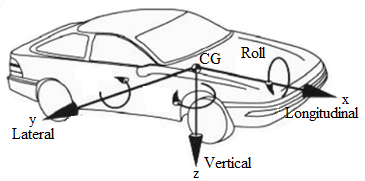

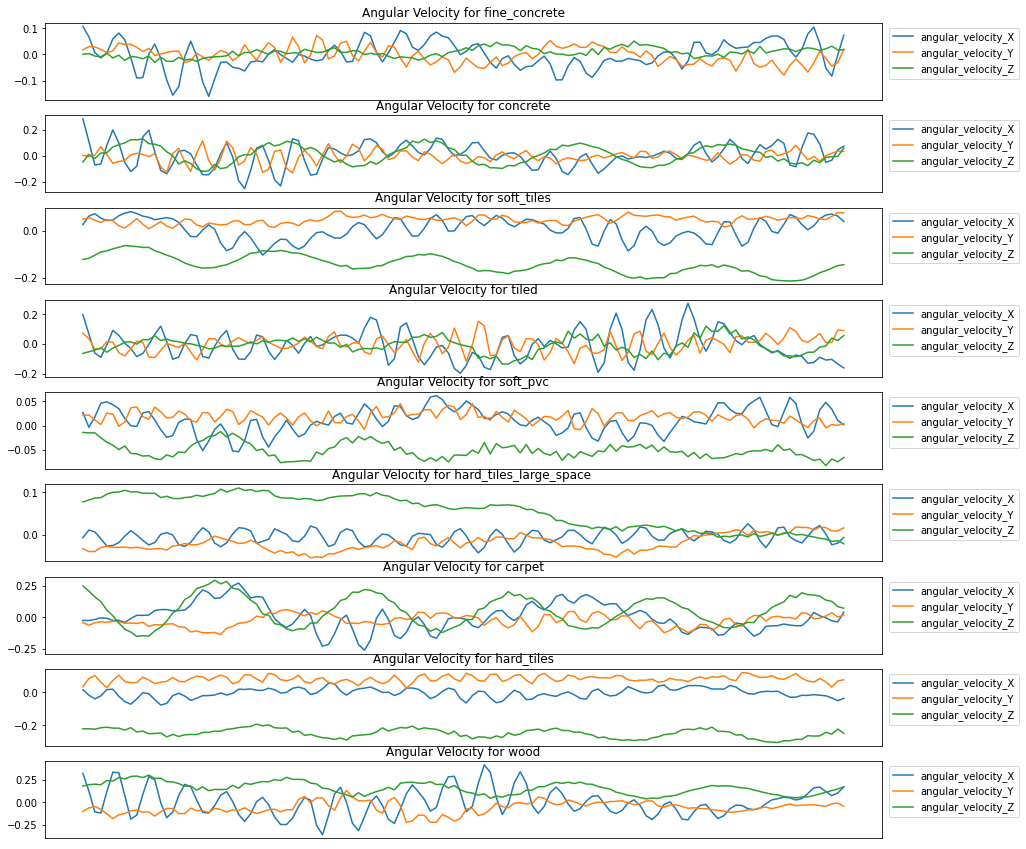

In [ ]:
def plot_angular_velocity(dfs):
  """ this function is plotting Angular velocity in x,y,z vs time for samples that we collected earlier"""

  plt.figure(figsize=(15,15))
  for i in range(0,9):
    plt.subplot(9,1,i+1)
    x=dfs[i]
    plt.plot(x['angular_velocity_X'])
    plt.plot(x['angular_velocity_Y'])
    plt.plot(x['angular_velocity_Z'])
    plt.legend(['angular_velocity_X','angular_velocity_Y','angular_velocity_Z'],bbox_to_anchor=(1.17, 1) ,loc='upper right')
    plt.xticks(ticks=[])
    plt.title(titles[i])
    plt.savefig('angular_velocity.png')
  plt.show()
plot_angular_velocity(dfs)

### 1) For floor type ***fine_concrete*** :- Readings of Y and Z axis are not fluctuating much, almost around zero , for X axis there is a bit of fluctuation which is not remarkable
### 2) For floor type ***Concrete*** :-Z axis shows some good sine wave type of structure which indicates body is slightly moving left and right when floor type is concrete while x and y axis does not show remarkable fluctuations and as time passes it goes near zero
### 3) For floor type ***soft_tiles*** :- Here Y axis is very smooth around zero though out test run, value of z axis is negative through out which indicates body is either leaned towards left or right based on sensor's position, x axis is less stable compared to y axis
### 4) For floor type ***tiled*** :- here x axis shows more fluctuation than any other axis which shows floor is uneven on left and right side of the robot
### 5) For floor type ***soft_pvc*** :- x and y axis are having less fluctuation while z is inclined towards any one direction out of two but not at remarkable extent
### 6) For floor type ***hard_tiles_large_space*** :- Here all three axis are almost uniform and aligned with 0
### 7) For floor type ***carpet*** :- Here z axis shows some positive value which is opposite to any other floor type's reading
### 8) For floor type ***hard_tiles*** :- Here X and Y axis are almost zero so very nominal deflection in those direction and as usual Z axis shows some value in negative direction

### 9) For floor type ***wood*** :- Angular velocity in x axis has some remarkable fluctuations comparatively and also z axis has positive value, y axis is almost uniform aligned to zero

In [ ]:
titles_2=['Linear Acceleration for fine_concrete','Linear Acceleration for concrete','Linear Acceleration for soft_tiles','Linear Acceleration for tiled','Linear Acceleration for soft_pvc','Linear Acceleration for hard_tiles_large_space ','Linear Acceleration for carpet','Linear Acceleration for hard_tiles','Linear Acceleration for wood']

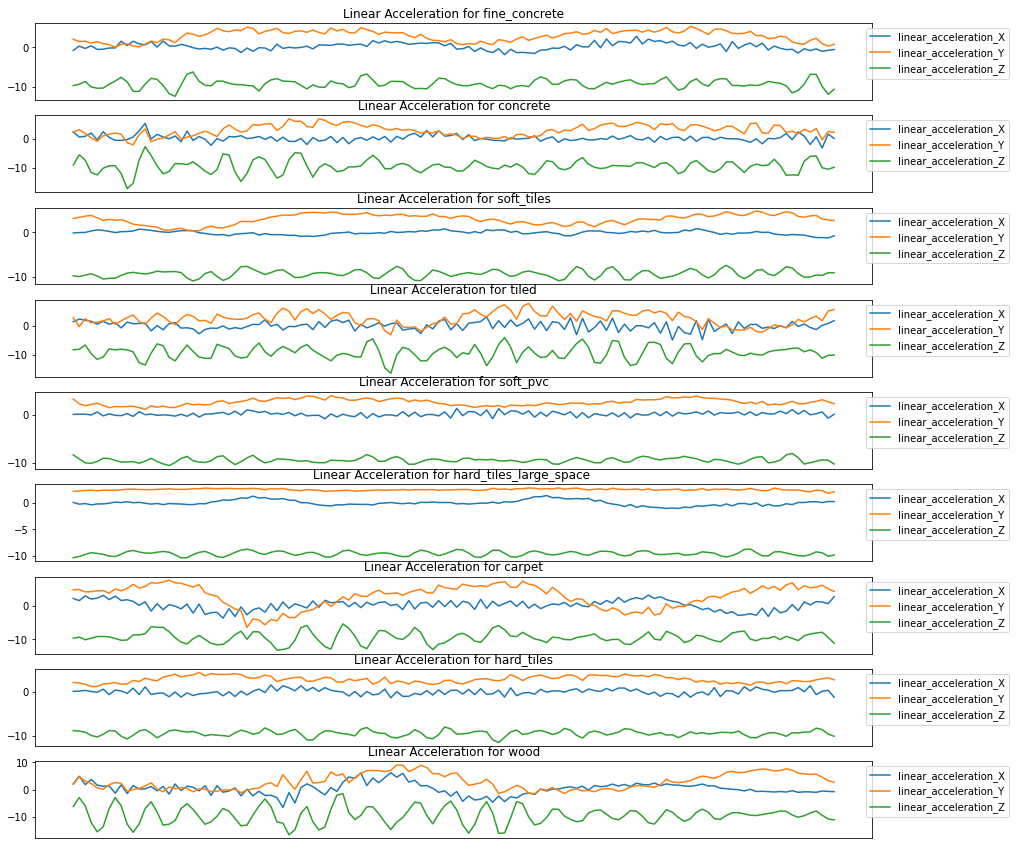

In [ ]:
def plot_linear_acceleration(dfs):
""" this function is plotting Linear acceleration in x,y,z vs time for samples that we collected earlier"""

  plt.figure(figsize=(15,15))
  for i in range(0,9):
    
    plt.subplot(9,1,i+1)
    x=dfs[i]
    plt.plot(x['linear_acceleration_X'])
    plt.plot(x['linear_acceleration_Y'])
    plt.plot(x['linear_acceleration_Z'])
    plt.legend(['linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z'],bbox_to_anchor=(1.17, 1) ,loc='upper right')
    plt.xticks(ticks=[])
    plt.title(titles_2[i])
    plt.savefig('linear_acceleration.png')
  plt.show()
plot_linear_acceleration(dfs)

### Here one thing to notice is that acceleration in z direction is always near -10 which is because gravitational force is continiously pulling robot downwards

### - other two directions are almost near zero which shows robot is not applying brakes abruptly and its moving uniformly

### - based on surface type and properties like smoothness,bumpiness robot is slightly changing its speed which we can notice from fluctuations

In [ ]:
titles_3=['Orientation for fine_concrete','Orientation for concrete','Orientation for soft_tiles','Orientation for tiled','Orientation for soft_pvc','Orientation for hard_tiles_large_space ','Orientation for carpet','Orientation for hard_tiles','Orientation for wood']

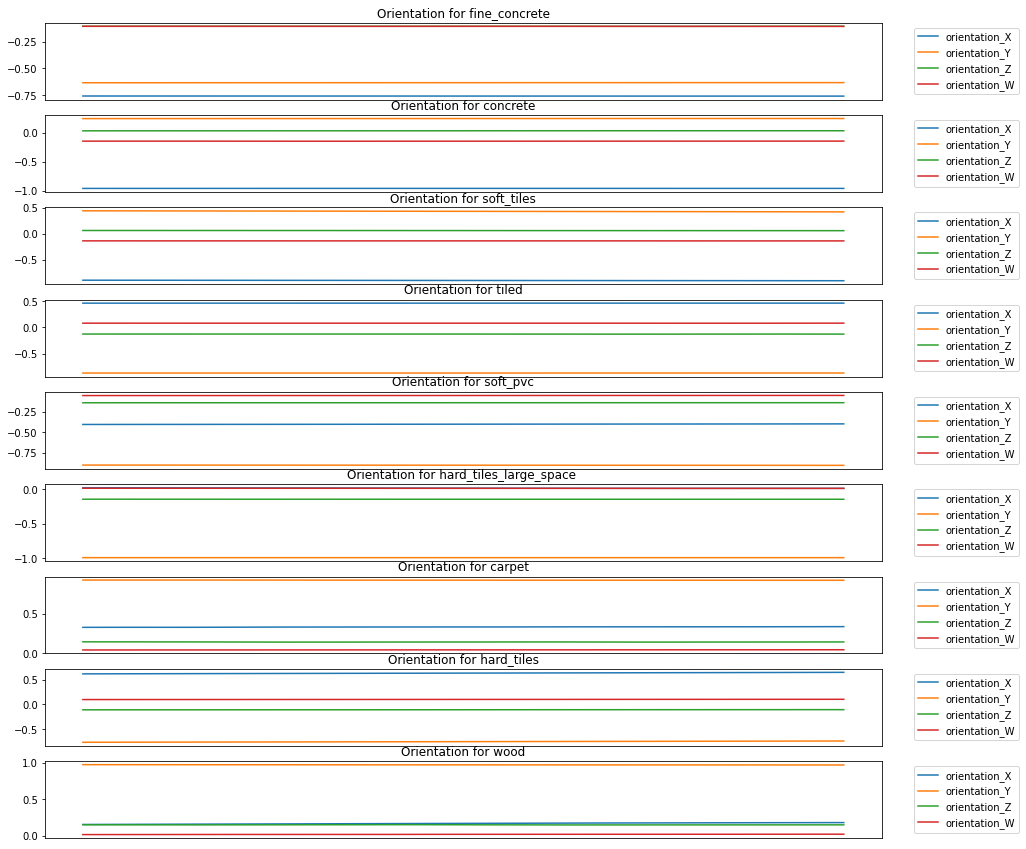

In [ ]:
def plot_orientation(dfs):
  """ this function is plotting Orientation in x,y,z,w vs time for samples that we collected earlier"""

  plt.figure(figsize=(15,15))
  for i in range(0,9):
    
    plt.subplot(9,1,i+1)
    x=dfs[i]
    plt.plot(x['orientation_X'])
    plt.plot(x['orientation_Y'])
    plt.plot(x['orientation_Z'])
    plt.plot(x['orientation_W'])
    plt.legend(['orientation_X','orientation_Y','orientation_Z','orientation_W'],bbox_to_anchor=(1.17, 1) ,loc='upper right')
    plt.xticks(ticks=[])
    plt.title(titles_3[i])
    plt.savefig('orientation.png')
  plt.show()
plot_orientation(dfs)


### Here orientation does not seem to change at all, its flat lines for all the floor types
### Values are varying for diffrent types floor but during one run its not changing much

### And if we notice orientation has 4 dimensions x,y,z and w and that is because of [Gimble lock](https://en.wikipedia.org/wiki/Gimbal_lock) problem,to avoid this problem orientation is representend in Quaternions representation in physics,for our application we can convert it into euler angles to represent orientation as longitudinal,vertical and lateral axis(as shown in above car image)



### Converting orientation to euler angles 

In [ ]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z


In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
x=list(train.orientation_X.values)
y=list(train.orientation_Y.values)
z=list(train.orientation_Z.values)
w=list(train.orientation_W.values)
e_x=[]
e_y=[]
e_z=[]

for i in range(0,len(x)):
  a,b,c=quaternion_to_euler(x[i], y[i], z[i], w[i])
  e_x.append(a)
  e_y.append(b)
  e_z.append(c)

In [ ]:
train['euler_x']=e_x
train['euler_y']=e_y
train['euler_z']=e_z

In [ ]:
titles_4=['Euler angles for fine_concrete','Euler angles for concrete','Euler angles for soft_tiles','Euler angles for tiled','Euler angles for soft_pvc','Euler angles for hard_tiles_large_space ','Euler angles for carpet','Euler angles for hard_tiles','Euler angles for wood']

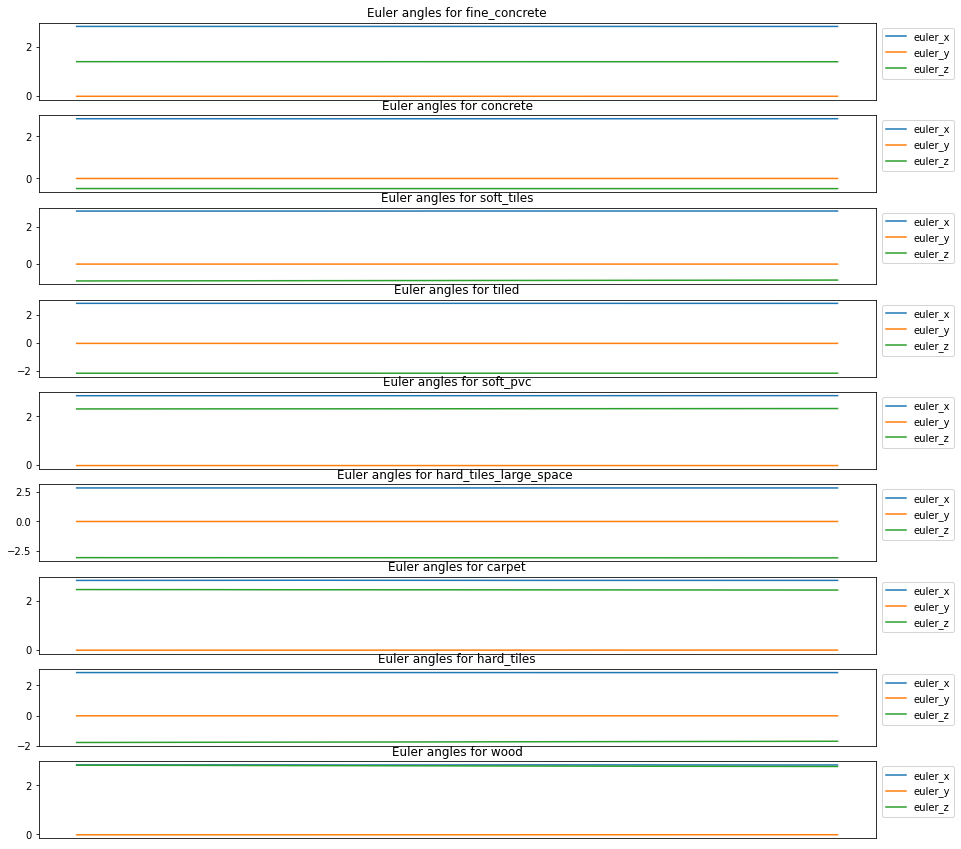

In [ ]:
def plot_euler(dfs):
  plt.figure(figsize=(15,15))
  for i in range(0,9):
    
    plt.subplot(9,1,i+1)
    x=dfs[i]
    plt.plot(x['euler_x'])
    plt.plot(x['euler_y'])
    plt.plot(x['euler_z'])
    
    plt.legend(['euler_x','euler_y','euler_z'],bbox_to_anchor=(1.1, 1) ,loc='upper right')
    plt.xticks(ticks=[])
    plt.title(titles_4[i])
    plt.savefig('euler.png')
  plt.show()
plot_euler(dfs)

### Here we can see similar type of results where values of position is changing as floor type changes but during run, its almost constant, 

### So this feature can help us get an idea what floor type it could be but it does not help us get info about diffrent properties of that floor type

## **Distribution of train and test Dataset**

Here we are checking how diffrent is the distribution of features in train and test dataset

In [ ]:
l=['angular_velocity_X','angular_velocity_Y','angular_velocity_Y','linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z','orientation_X','orientation_Y','orientation_Z']

In [ ]:
def distribution(data):
  plt.figure(figsize=(12,12))
  for i in range(0,9):
    
    sns.set_palette("Set1", desat=0.80)
    facetgrid = sns.FacetGrid(data, hue='surface', size=10,aspect=1)
    facetgrid.map(sns.distplot,l[i], hist=False)\
        .add_legend()
    
    plt.show();

<Figure size 864x864 with 0 Axes>

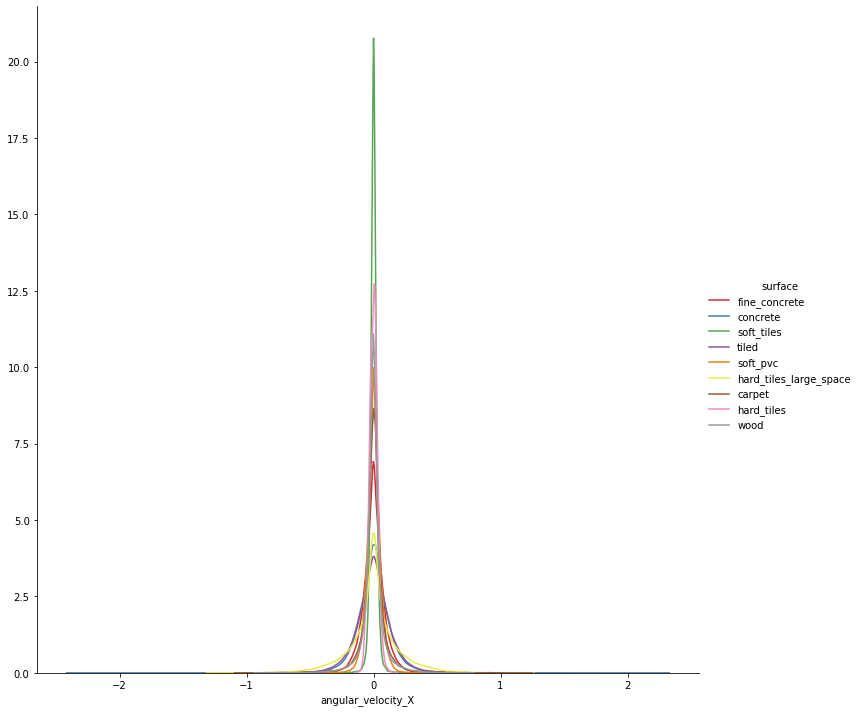

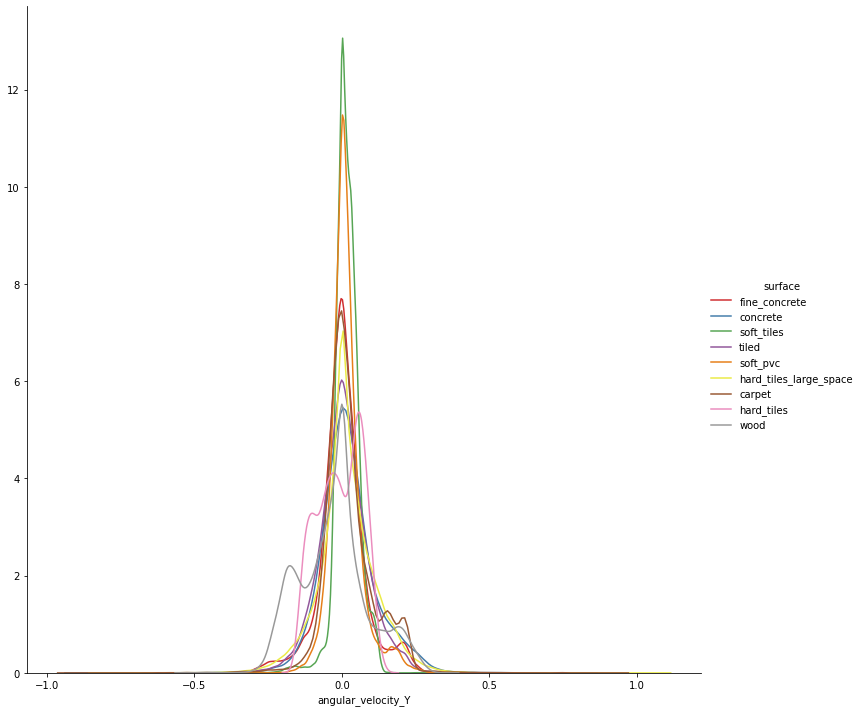

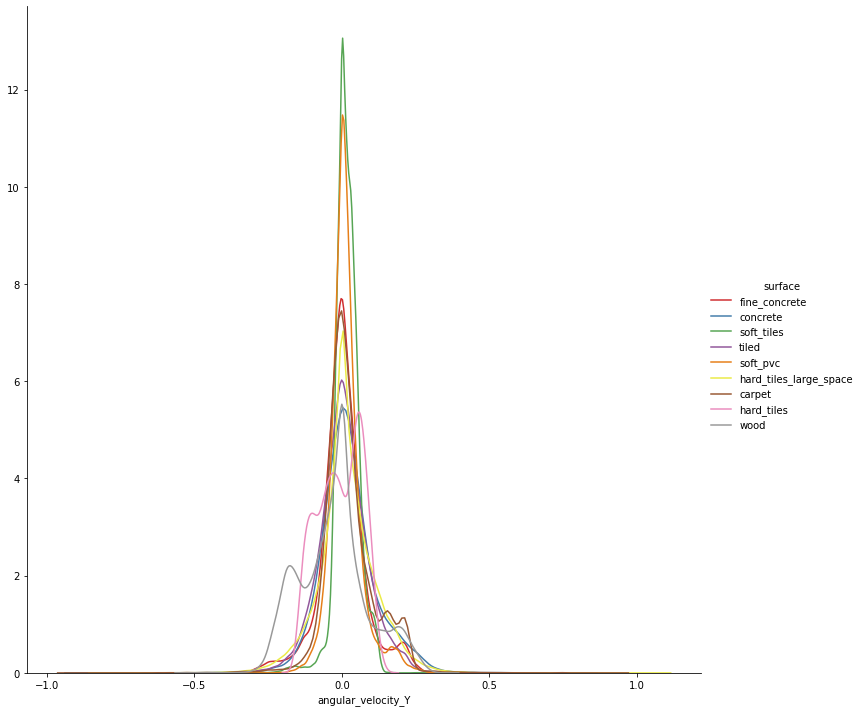

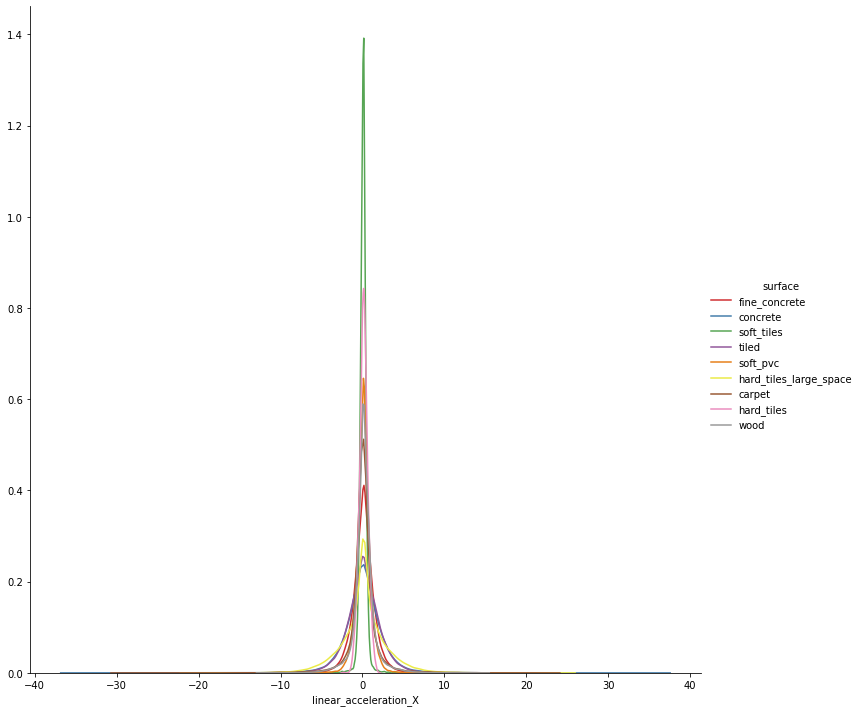

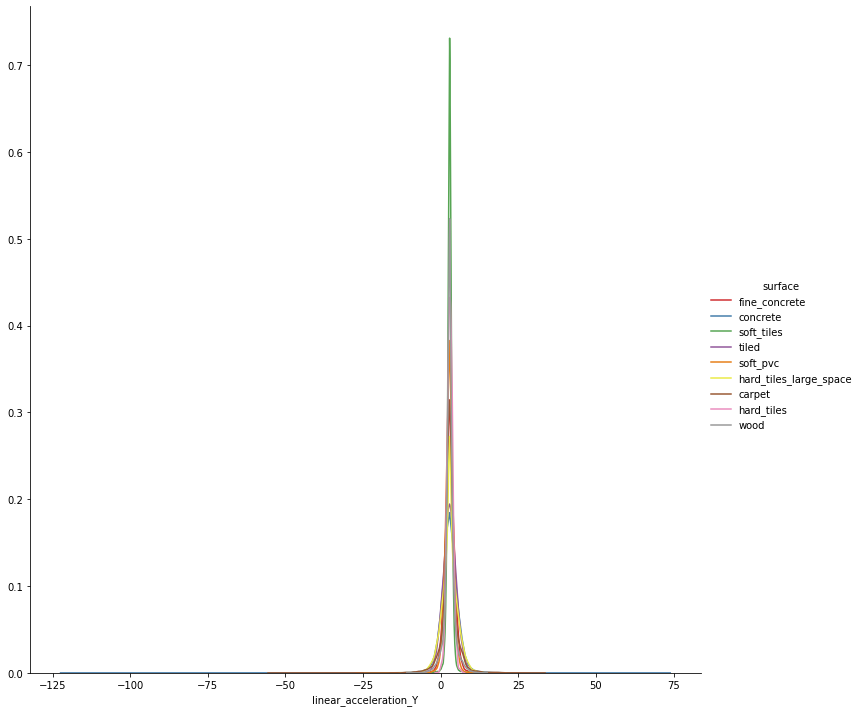

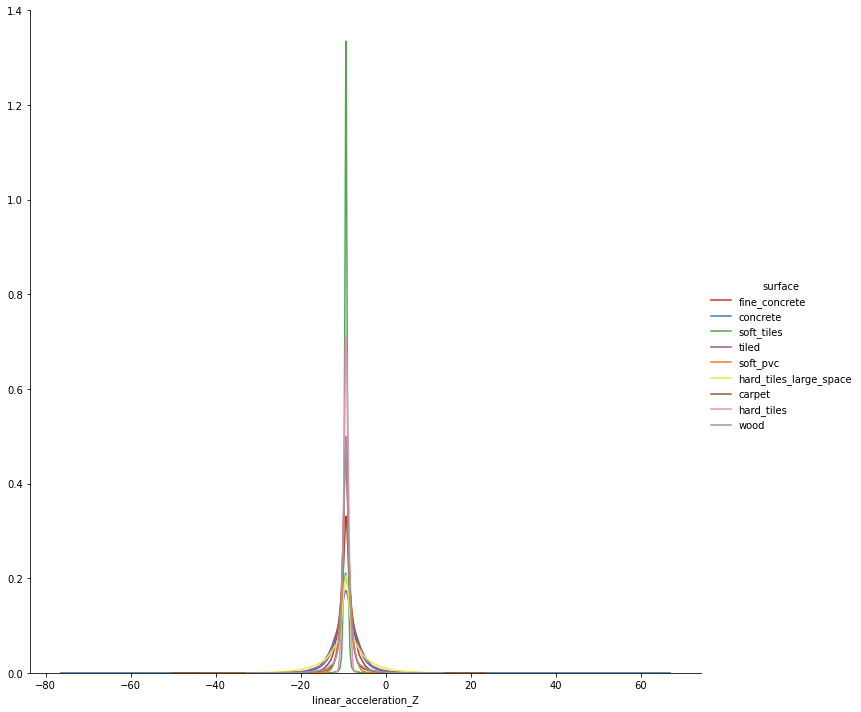

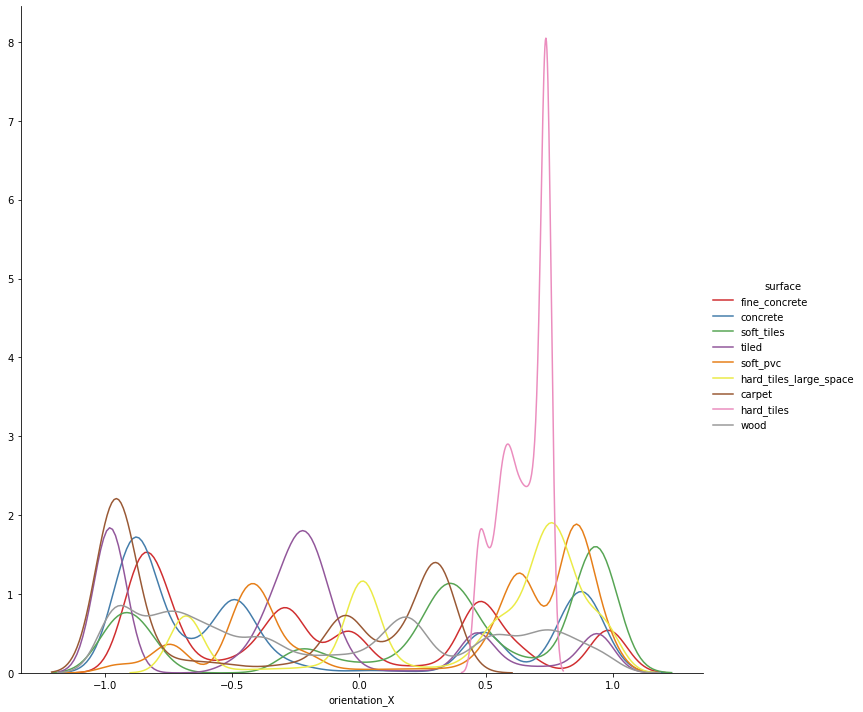

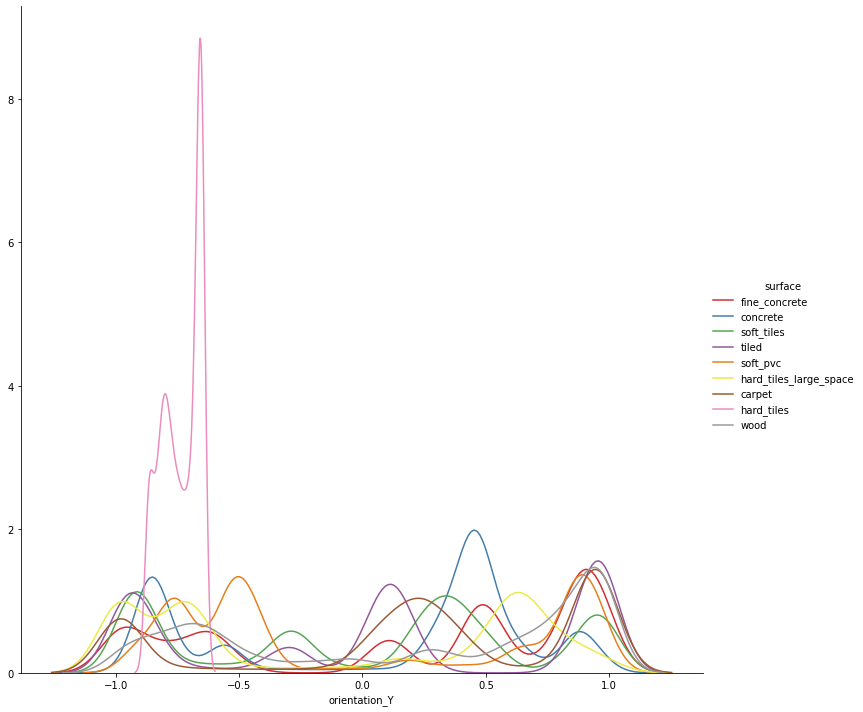

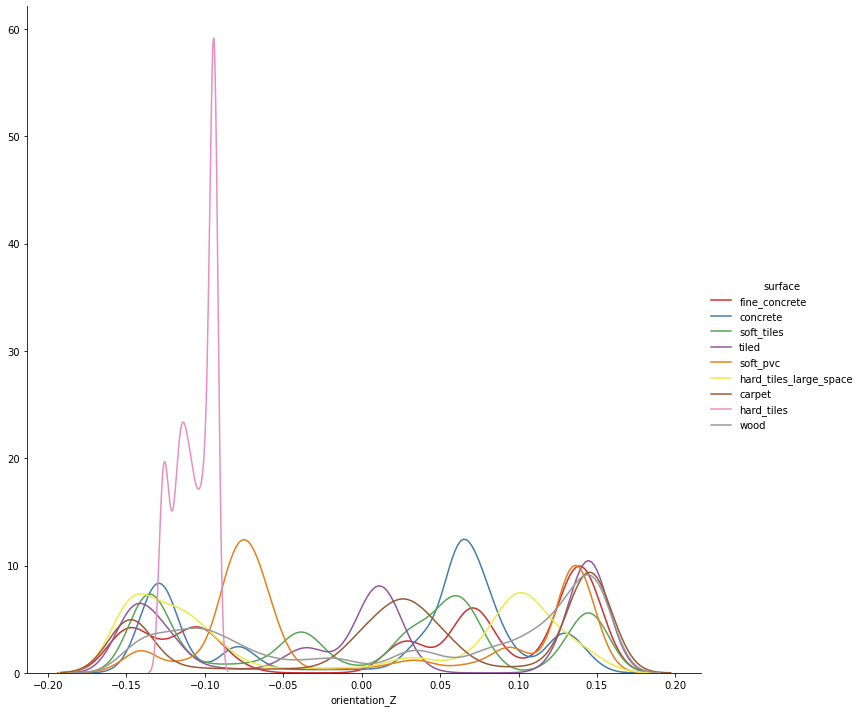

In [ ]:
distribution(data)

### Based on above graphs, its difficult to distinguish diffrent classes, they are overlapping, but in case of orientation fine concrete has a bit diffrent distribution 

In [ ]:
train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


### linear acceleration X has values between -36 to 36 Y has -121 to 73 Z has -75 to 65
### seems like this feature has some outliers
### We will replace outliers (keeping 99th or 100th percentile value as threshold of train set) and will replace it with mean in both train and test dataset

In [ ]:
x=list(train.linear_acceleration_X.values)
y=list(train.linear_acceleration_Y.values)
z=list(train.linear_acceleration_Z.values)

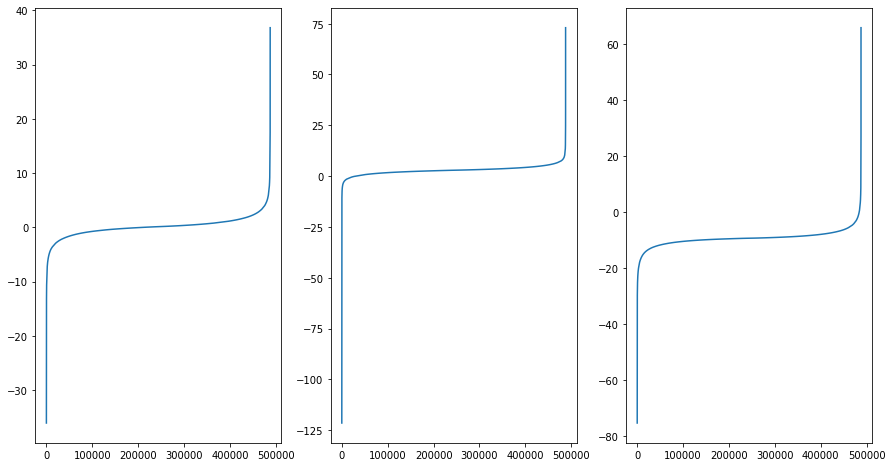

In [ ]:
plt.figure(figsize=(15,8))
x.sort()
y.sort()
z.sort()
plt.subplot(1,3,1)
plt.plot(x)
plt.subplot(1,3,2)
plt.plot(y)
plt.subplot(1,3,3)
plt.plot(z)
plt.show()

In [ ]:
def percentile(x):
  for i in range(0,100):
      var =x
      var = np.sort(var,axis = None)
      print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
  print("100 percentile value is ",var[-1])
  print("*"*50)
percentile(x)

0 percentile value is -36.067
1 percentile value is -5.312
2 percentile value is -4.0635
3 percentile value is -3.4289
4 percentile value is -2.9772
5 percentile value is -2.6434
6 percentile value is -2.3719
7 percentile value is -2.1507
8 percentile value is -1.9666
9 percentile value is -1.8023
10 percentile value is -1.6568
11 percentile value is -1.5271
12 percentile value is -1.4095
13 percentile value is -1.3015
14 percentile value is -1.2063
15 percentile value is -1.1192
16 percentile value is -1.0379
17 percentile value is -0.9638200000000001
18 percentile value is -0.89646
19 percentile value is -0.83349
20 percentile value is -0.77549
21 percentile value is -0.72115
22 percentile value is -0.67083
23 percentile value is -0.62212
24 percentile value is -0.57473
25 percentile value is -0.53083
26 percentile value is -0.48958999999999997
27 percentile value is -0.44983999999999996
28 percentile value is -0.41276999999999997
29 percentile value is -0.37711999999999996
30 percen

In [ ]:
percentile(y)

0 percentile value is -121.49
1 percentile value is -2.7147
2 percentile value is -1.6327
3 percentile value is -1.0374
4 percentile value is -0.63297
5 percentile value is -0.30864
6 percentile value is -0.048112
7 percentile value is 0.16725
8 percentile value is 0.35759
9 percentile value is 0.52667
10 percentile value is 0.67685
11 percentile value is 0.8164899999999999
12 percentile value is 0.9420799999999999
13 percentile value is 1.0572
14 percentile value is 1.1623
15 percentile value is 1.2596
16 percentile value is 1.3505
17 percentile value is 1.4347
18 percentile value is 1.5144
19 percentile value is 1.5886
20 percentile value is 1.6607
21 percentile value is 1.7281
22 percentile value is 1.7885
23 percentile value is 1.8479
24 percentile value is 1.9048
25 percentile value is 1.9579
26 percentile value is 2.011
27 percentile value is 2.0618
28 percentile value is 2.1109
29 percentile value is 2.1569
30 percentile value is 2.202
31 percentile value is 2.2455
32 percentile

In [ ]:
percentile(z)

0 percentile value is -75.38600000000001
1 percentile value is -18.185
2 percentile value is -15.99
3 percentile value is -14.770999999999999
4 percentile value is -13.982000000000001
5 percentile value is -13.414000000000001
6 percentile value is -12.968
7 percentile value is -12.607000000000001
8 percentile value is -12.315999999999999
9 percentile value is -12.061
10 percentile value is -11.837
11 percentile value is -11.642999999999999
12 percentile value is -11.468
13 percentile value is -11.314
14 percentile value is -11.167
15 percentile value is -11.04
16 percentile value is -10.921
17 percentile value is -10.814
18 percentile value is -10.715
19 percentile value is -10.624
20 percentile value is -10.539000000000001
21 percentile value is -10.459000000000001
22 percentile value is -10.386
23 percentile value is -10.318
24 percentile value is -10.254000000000001
25 percentile value is -10.193
26 percentile value is -10.136000000000001
27 percentile value is -10.083
28 percentile

### There are definiately outliers in data, we can replace those with 'mean' in both train and test set

#### For linear_acceleration_x threshold is -5 to 5

In [ ]:
c=list(train.linear_acceleration_X.values)
train.loc[train.linear_acceleration_X<-5, 'linear_acceleration_X'] = np.nan
train.loc[train.linear_acceleration_X>5, 'linear_acceleration_X'] = np.nan

test.loc[test.linear_acceleration_X<-5, 'linear_acceleration_X'] = np.nan
test.loc[test.linear_acceleration_X>5, 'linear_acceleration_X'] = np.nan

m=np.mean(c)
train.fillna(m,inplace=True)
test.fillna(m,inplace=True)


#### For linear_acceleration_y threshold is -2.8 to 8.6

In [ ]:
c=list(train.linear_acceleration_Y.values)
train.loc[train.linear_acceleration_Y<-2.8, 'linear_acceleration_Y'] = np.nan
train.loc[train.linear_acceleration_Y>8.6, 'linear_acceleration_Y'] = np.nan

test.loc[test.linear_acceleration_Y<-2.8, 'linear_acceleration_Y'] = np.nan
test.loc[test.linear_acceleration_Y>8.6, 'linear_acceleration_Y'] = np.nan


m=np.median(c)

train.fillna(m,inplace=True)
test.fillna(m,inplace=True)

#### For linear_acceleration_z threshold is -18.2 to -0.68

In [ ]:
c=list(train.linear_acceleration_Z.values)
train.loc[train.linear_acceleration_Z<-18.2, 'linear_acceleration_Z'] = np.nan
train.loc[train.linear_acceleration_Z>-0.68, 'linear_acceleration_Z'] = np.nan

test.loc[test.linear_acceleration_Z<-18.2, 'linear_acceleration_Z'] = np.nan
test.loc[test.linear_acceleration_Z>-0.68, 'linear_acceleration_Z'] = np.nan


m=np.median(c)
train.fillna(m,inplace=True)
test.fillna(m,inplace=True)

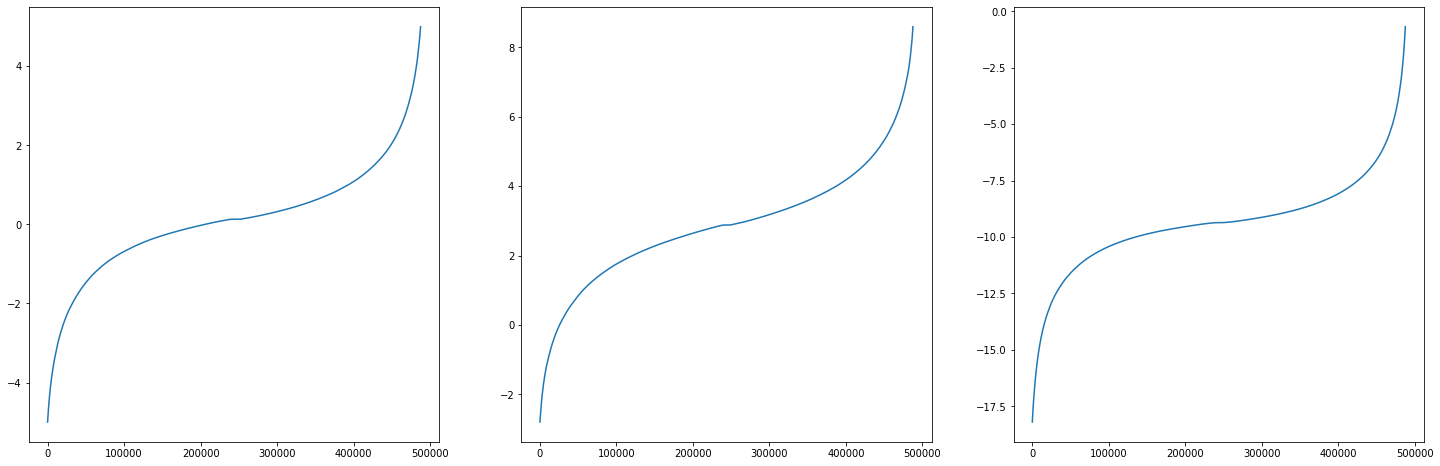

In [ ]:
x=list(train.linear_acceleration_X.values)
y=list(train.linear_acceleration_Y.values)
z=list(train.linear_acceleration_Z.values)

plt.figure(figsize=(25,8))
x.sort()
y.sort()
z.sort()
plt.subplot(1,3,1)
plt.plot(x)
plt.subplot(1,3,2)
plt.plot(y)
plt.subplot(1,3,3)
plt.plot(z)
plt.show()

In [ ]:
train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.119933,2.883407,-9.363587
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.399997,1.707612,2.133612
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-4.999700,-2.799600,-18.199000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.482320,2.008500,-10.136000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.129281,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.736190,3.746700,-8.580900
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,4.999800,8.599800,-0.680000


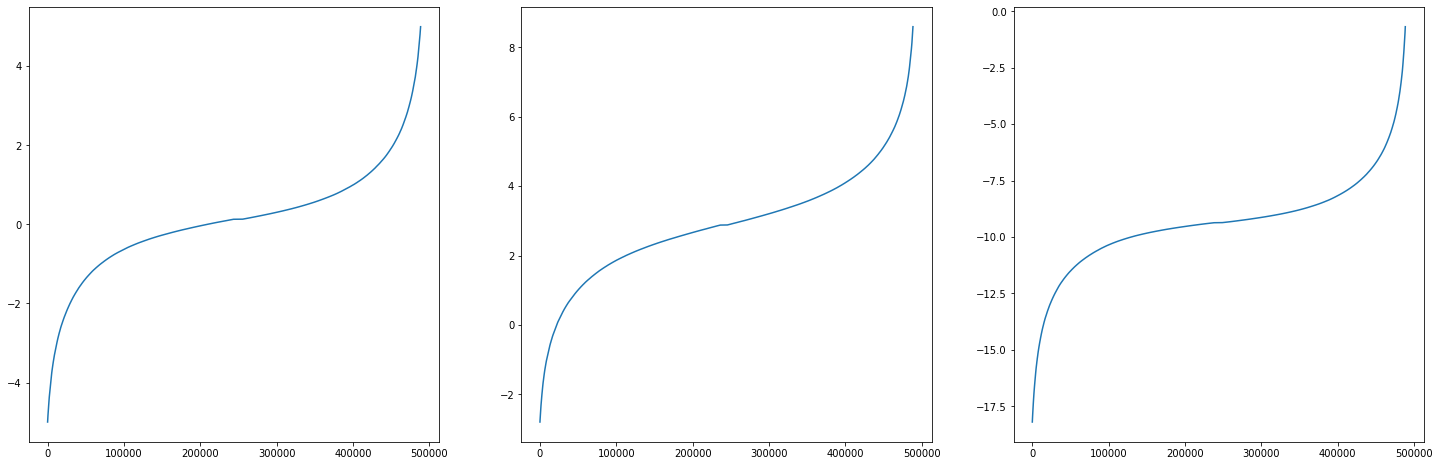

In [ ]:
x=list(test.linear_acceleration_X.values)
y=list(test.linear_acceleration_Y.values)
z=list(test.linear_acceleration_Z.values)
plt.figure(figsize=(25,8))
x.sort()
y.sort()
z.sort()
plt.subplot(1,3,1)
plt.plot(x)
plt.subplot(1,3,2)
plt.plot(y)
plt.subplot(1,3,3)
plt.plot(z)
plt.show()

In [ ]:
test.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.114883,2.903967,-9.359214
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.344521,1.617162,2.078873
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-4.999900,-2.799900,-18.199000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.448440,2.092900,-10.074000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.129281,2.879600,-9.365300
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.680460,3.715500,-8.633700
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,4.999900,8.599900,-0.680060


## Correlation

In [ ]:
train

,Unnamed: 0,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


# **Feature Engineering**

In [ ]:
x=list(train.orientation_X.values)
y=list(train.orientation_Y.values)
z=list(train.orientation_Z.values)
w=list(train.orientation_W.values)
e_x=[]
e_y=[]
e_z=[]

for i in range(0,len(x)):
  a,b,c=quaternion_to_euler(x[i], y[i], z[i], w[i])
  e_x.append(a)
  e_y.append(b)
  e_z.append(c)
train['euler_x']=e_x
train['euler_y']=e_y
train['euler_z']=e_z

In [ ]:
x=list(test.orientation_X.values)
y=list(test.orientation_Y.values)
z=list(test.orientation_Z.values)
w=list(test.orientation_W.values)
e_x=[]
e_y=[]
e_z=[]

for i in range(0,len(x)):
  a,b,c=quaternion_to_euler(x[i], y[i], z[i], w[i])
  e_x.append(a)
  e_y.append(b)
  e_z.append(c)
test['euler_x']=e_x
test['euler_y']=e_y
test['euler_z']=e_z

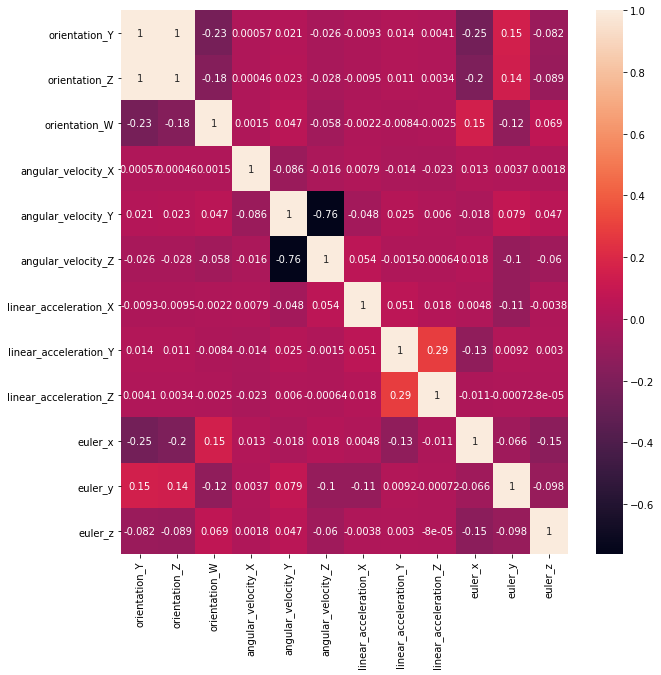

In [ ]:
train_=train.iloc[:,4:].corr()
test_=test.iloc[:,4:].corr()


plt.figure(figsize=(10,10))
sns.heatmap(train_,annot=True)
plt.show()

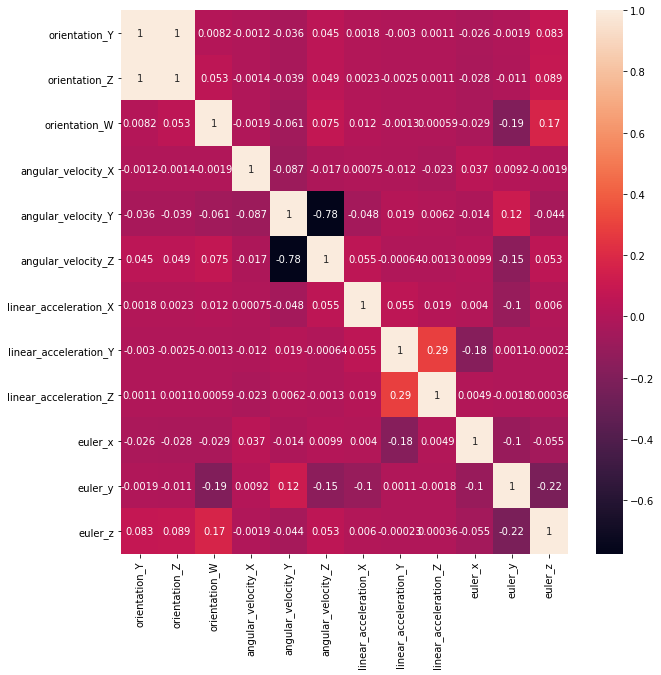

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(test_,annot=True)

### Here as we can see some of the orientations features are highly correlated with each other(w and x, Z and Y) on the other hand euler angles are not that highly correlated.

In [ ]:
# Adding total angular velocity and total acceleration define as total=sqrt(x**2+y**2+z**2)

train['total_angular_velocity'] = (train['angular_velocity_X'] ** 2 + train['angular_velocity_Y'] ** 2 + train['angular_velocity_Z'] ** 2) ** 0.5
train['total_linear_acceleration'] = (train['linear_acceleration_X'] ** 2 + train['linear_acceleration_Y'] ** 2 + train['linear_acceleration_Z'] ** 2) ** 0.5

test['total_angular_velocity'] = (test['angular_velocity_X'] ** 2 + test['angular_velocity_Y'] ** 2 + test['angular_velocity_Z'] ** 2) ** 0.5
test['total_linear_acceleration'] = (test['linear_acceleration_X'] ** 2 + test['linear_acceleration_Y'] ** 2 + test['linear_acceleration_Z'] ** 2) ** 0.5

In [ ]:
train.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_processed_for_FE.csv')
test.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_processed_for_FE.csv')

### total_angular-velocity and total_linear_acceleration is like resultant of these features so converting from 3d to one signal

In [ ]:
train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_x,euler_y,euler_z,total_angular_velocity,total_linear_acceleration
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,2.843272,-0.024668,1.396664,0.109076,10.005392
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,2.843199,-0.024662,1.396646,0.074240,9.538638
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,2.843224,-0.024728,1.396682,0.030428,8.874697
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,2.843186,-0.024770,1.396721,0.025082,10.164638
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,2.843195,-0.024784,1.396693,0.010603,10.556132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063,2.907700,-0.018571,-1.768404,0.170809,9.791029
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257,2.907732,-0.018575,-1.768079,0.137166,9.749472
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443,2.907657,-0.018699,-1.767856,0.142452,9.581853
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435,2.907480,-0.018655,-1.767534,0.148026,10.855816


In [ ]:
test

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_x,euler_y,euler_z,total_angular_velocity,total_linear_acceleration
0,0_0,0,0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.187870,0.29492,2.8027,-9.6816,2.842566,-0.014819,-0.790892,0.209765,10.083426
1,0_1,0,1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.182060,0.14944,2.5408,-9.8521,2.842597,-0.014811,-0.790278,0.194660,10.175553
2,0_2,0,2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.184410,-0.49741,2.5853,-9.3835,2.842505,-0.014748,-0.789807,0.189096,9.745833
3,0_3,0,3,0.91237,-0.38121,-0.050588,0.14035,-0.024217,0.037788,-0.187830,-0.32376,2.9966,-8.7415,2.842446,-0.014696,-0.789337,0.193118,9.246527
4,0_4,0,4,0.91247,-0.38096,-0.050546,0.14042,-0.038047,0.083405,-0.201700,-0.70103,2.6498,-8.8432,2.842347,-0.014746,-0.788789,0.221556,9.258243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488443,3815_123,3815,123,0.89516,-0.42026,-0.056425,0.13744,0.036579,0.008990,-0.008570,0.76537,3.5421,-8.4445,2.843689,-0.014503,-0.875697,0.038630,9.189224
488444,3815_124,3815,124,0.89517,-0.42025,-0.056391,0.13742,0.022401,0.021198,-0.010905,-0.48107,3.3380,-8.8012,2.843755,-0.014543,-0.875664,0.032712,9.425221
488445,3815_125,3815,125,0.89521,-0.42019,-0.056343,0.13734,0.033571,0.019868,-0.007203,0.44106,3.2110,-9.3700,2.843939,-0.014541,-0.875517,0.039669,9.914734
488446,3815_126,3815,126,0.89522,-0.42019,-0.056300,0.13730,0.046988,0.015570,0.001514,-0.25947,2.8634,-9.8546,2.844049,-0.014583,-0.875504,0.049524,10.265453


### So finally we have 18 signals for train and test dataset
### On these 18 signals we can perform few operations and get features like
**mean**
,**median**
,**max**
,**AUC**
,**Fourier transform**
,**std**
,**var**
,**percentile**
,**IQR**
,**energy**
,**entropy**
,**kurtosis**
,**skewness** etc
### and these features can be extracted automatically using library called  time series feature extraction library TSFEL

# Feature set 1:- Using TSFEL to extract features

In [ ]:
train_X = train.iloc[:,4:].values.reshape(3810,128,14)
test_X=test.iloc[:,4:].values.reshape(3816,128,14)

In [ ]:
train_X.shape,test_X.shape

((3810, 128, 14), (3816, 128, 14))

In [ ]:
# here using time series feature extraction library
#https://tsfel.readthedocs.io/en/latest/
import tsfel
import pandas as pd




cfg = tsfel.get_features_by_domain()


train_X = tsfel.time_series_features_extractor(cfg, train_X)

*** Feature extraction started ***



*** Feature extraction finished ***


In [ ]:
test_X=tsfel.time_series_features_extractor(cfg, test_X)

*** Feature extraction started ***



*** Feature extraction finished ***


In [ ]:
# extracted features

'''abs_energy(signal)            	Computes the absolute energy of the signal.
auc(signal, fs)	                Computes the area under the curve of the signal computed with trapezoid rule.
autocorr(signal)        	      Computes autocorrelation of the signal.
calc_centroid(signal, fs)	      Computes the centroid along the time axis.
calc_max(signal)                Computes the maximum value of the signal.
calc_mean(signal)	              Computes mean value of the signal.
calc_median(signal)	            Computes median of the signal.
calc_min(signal)	              Computes the minimum value of the signal.
calc_std(signal)	              Computes standard deviation (std) of the signal.
calc_var(signal)	              Computes variance of the signal.
distance(signal)              	Computes signal traveled distance.
ecdf(signal[, d])             	Computes the values of ECDF (empirical cumulative distribution function) along the time axis.
ecdf_percentile(signal[, percentile])	              Computes the percentile values of the ECDF.
ecdf_percentile_count(signal[, percentile])	        Computes the cumulative sum of samples that are less than the percentile.
entropy(signal[, prob])	                            Computes the entropy of the signal using the Shannon Entropy.
fft_mean_coeff(signal, fs[, nfreq])	                Computes the mean value of each spectrogram frequency.
fundamental_frequency(signal, fs)	                  Computes fundamental frequency of the signal.
hist(signal[, nbins, r])	                          Computes histogram of the signal.
human_range_energy(signal, fs)	                    Computes the human range energy ratio.
interq_range(signal)                              	Computes interquartile range of the signal.
kurtosis(signal)                                  	Computes kurtosis of the signal.
lpcc(signal[, n_coeff])	                            Computes the linear prediction cepstral coefficients.
max_frequency(signal, fs)	                          Computes maximum frequency of the signal.
max_power_spectrum(signal, fs)	                    Computes maximum power spectrum density of the signal.
mean_abs_deviation(signal)	                        Computes mean absolute deviation of the signal.
mean_abs_diff(signal)	                              Computes mean absolute differences of the signal.
mean_diff(signal)	                                  Computes mean of differences of the signal.
median_abs_deviation(signal)	                      Computes median absolute deviation of the signal.
median_abs_diff(signal)	                            Computes median absolute differences of the signal.
median_diff(signal)	                                Computes median of differences of the signal.
median_frequency(signal, fs)	                      Computes median frequency of the signal.
mfcc(signal, fs[, pre_emphasis, nfft, …])         	Computes the MEL cepstral coefficients.
negative_turning(signal)	                          Computes number of negative turning points of the signal.
neighbourhood_peaks(signal[, n])	                  Computes the number of peaks from a defined neighbourhood of the signal.
pk_pk_distance(signal)	                            Computes the peak to peak distance.
positive_turning(signal)	                          Computes number of positive turning points of the signal.
power_bandwidth(signal, fs)	                        Computes power spectrum density bandwidth of the signal.
rms(signal)	                                        Computes root mean square of the signal.
skewness(signal)	                                  Computes skewness of the signal.
slope(signal)	                                      Computes the slope of the signal.
spectral_centroid(signal, fs)	                      Barycenter of the spectrum.
spectral_decrease(signal, fs)	                      Represents the amount of decreasing of the spectra amplitude.
spectral_distance(signal, fs)	                      Computes the signal spectral distance.
spectral_entropy(signal, fs)	                      Computes the spectral entropy of the signal based on Fourier transform.
spectral_kurtosis(signal, fs)	                      Measures the flatness of a distribution around its mean value.
spectral_positive_turning(signal, fs)	              Computes number of positive turning points of the fft magnitude signal.
spectral_roll_off(signal, fs)	                      Computes the spectral roll-off of the signal.
spectral_roll_on(signal, fs)	                      Computes the spectral roll-on of the signal.
spectral_skewness(signal, fs)	                      Measures the asymmetry of a distribution around its mean value.
spectral_slope(signal, fs)	                        Computes the spectral slope.
spectral_spread(signal, fs)	                        Measures the spread of the spectrum around its mean value.
spectral_variation(signal, fs)	                    Computes the amount of variation of the spectrum along time.
sum_abs_diff(signal)	                              Computes sum of absolute differences of the signal.
total_energy(signal, fs)	                          Computes the total energy of the signal.
wavelet_abs_mean(signal[, function, widths])      	Computes CWT absolute mean value of each wavelet scale.
wavelet_energy(signal[, function, widths])	        Computes CWT energy of each wavelet scale.
wavelet_entropy(signal[, function, widths])	        Computes CWT entropy of the signal.
wavelet_std(signal[, function, widths])	            Computes CWT std value of each wavelet scale.
wavelet_var(signal[, function, widths])	            Computes CWT variance value of each wavelet scale.
zero_cross(signal)	                                Computes Zero-crossing rate of the signal.'''

In [ ]:
train_X

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Entropy,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_2,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,...,9_Total energy,9_Variance,9_Wavelet absolute mean_0,9_Wavelet absolute mean_1,9_Wavelet absolute mean_2,9_Wavelet absolute mean_3,9_Wavelet absolute mean_4,9_Wavelet absolute mean_5,9_Wavelet absolute mean_6,9_Wavelet absolute mean_7,9_Wavelet absolute mean_8,9_Wavelet energy_0,9_Wavelet energy_1,9_Wavelet energy_2,9_Wavelet energy_3,9_Wavelet energy_4,9_Wavelet energy_5,9_Wavelet energy_6,9_Wavelet energy_7,9_Wavelet energy_8,9_Wavelet entropy,9_Wavelet standard deviation_0,9_Wavelet standard deviation_1,9_Wavelet standard deviation_2,9_Wavelet standard deviation_3,9_Wavelet standard deviation_4,9_Wavelet standard deviation_5,9_Wavelet standard deviation_6,9_Wavelet standard deviation_7,9_Wavelet standard deviation_8,9_Wavelet variance_0,9_Wavelet variance_1,9_Wavelet variance_2,9_Wavelet variance_3,9_Wavelet variance_4,9_Wavelet variance_5,9_Wavelet variance_6,9_Wavelet variance_7,9_Wavelet variance_8,9_Zero crossing rate
0,51.451639,0.805193,51.451639,0.634489,25.0,102.0,-0.63443,-0.63340,0.007812,0.015625,0.023438,0.03125,0.039062,0.046875,0.054688,0.0625,0.070312,0.078125,0.860610,9.949134e-10,2.011502e-07,2.396870e-11,1.314703e-11,1.650979e-12,4.056826e-12,2.829151e-12,2.158166e-12,1.306691e-13,6.629204e-12,3.035930e-12,1.900204e-12,2.616636e-08,1.115676e-12,7.265332e-12,7.221689e-12,1.982570e-13,8.955069e-12,5.678532e-13,2.753380e-13,3.849088e-12,...,813.904031,9.948055e-07,0.036407,0.107844,0.199350,0.307523,0.430141,0.565676,0.712996,0.871225,1.039655,0.218863,0.416873,0.619860,0.824073,1.028755,1.233653,1.438650,1.643671,1.848661,1.932107,0.215813,0.402682,0.586930,0.764543,0.934514,1.096317,1.249541,1.393780,1.528615,0.046575,0.162153,0.344486,0.584526,0.873316,1.201911,1.561352,1.942622,2.336664,0.0
1,7.487983,0.307175,7.487983,0.636234,25.0,102.0,0.24141,0.24235,0.007812,0.015625,0.023438,0.03125,0.039062,0.046875,0.054688,0.0625,0.070312,0.078125,0.912903,1.707118e-09,1.169866e-07,1.076756e-10,4.034950e-11,3.391615e-12,9.027590e-12,4.931945e-12,3.464566e-12,3.389954e-12,1.828854e-12,1.157896e-12,5.080447e-13,1.589496e-08,1.476416e-12,2.203453e-11,1.596174e-11,1.509947e-11,2.216969e-11,1.205569e-11,4.055122e-11,3.497975e-10,...,812.984913,1.238718e-06,0.036389,0.107781,0.199228,0.307333,0.429881,0.565343,0.712590,0.870743,1.039095,0.218773,0.416630,0.619437,0.823445,1.027983,1.232783,1.437729,1.642744,1.847760,1.932160,0.215726,0.402448,0.586524,0.763943,0.933783,1.095509,1.248711,1.392987,1.527906,0.046538,0.161964,0.344010,0.583609,0.871951,1.200141,1.559279,1.940413,2.334497,0.0
2,91.648751,1.074635,91.648751,0.634320,25.0,102.0,-0.84695,-0.84535,0.007812,0.015625,0.023438,0.03125,0.039062,0.046875,0.054688,0.0625,0.070312,0.078125,0.954219,7.344449e-10,4.583877e-07,8.134631e-11,2.805822e-11,8.556686e-13,2.972242e-13,2.720231e-12,5.347754e-12,8.193806e-12,5.699073e-12,1.569013e-12,9.257907e-13,5.980865e-08,5.728600e-13,1.424283e-11,2.774105e-12,4.897211e-12,8.197199e-13,8.029933e-13,2.906116e-12,4.888179e-12,...,816.078991,1.173272e-06,0.036451,0.107963,0.199561,0.307845,0.430594,0.566281,0.713778,0.872205,1.040854,0.219157,0.417355,0.620469,0.824749,1.029500,1.234507,1.439675,1.644920,1.850165,1.932149,0.216104,0.40

In [ ]:
test_X

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Entropy,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_2,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,...,9_Total energy,9_Variance,9_Wavelet absolute mean_0,9_Wavelet absolute mean_1,9_Wavelet absolute mean_2,9_Wavelet absolute mean_3,9_Wavelet absolute mean_4,9_Wavelet absolute mean_5,9_Wavelet absolute mean_6,9_Wavelet absolute mean_7,9_Wavelet absolute mean_8,9_Wavelet energy_0,9_Wavelet energy_1,9_Wavelet energy_2,9_Wavelet energy_3,9_Wavelet energy_4,9_Wavelet energy_5,9_Wavelet energy_6,9_Wavelet energy_7,9_Wavelet energy_8,9_Wavelet entropy,9_Wavelet standard deviation_0,9_Wavelet standard deviation_1,9_Wavelet standard deviation_2,9_Wavelet standard deviation_3,9_Wavelet standard deviation_4,9_Wavelet standard deviation_5,9_Wavelet standard deviation_6,9_Wavelet standard deviation_7,9_Wavelet standard deviation_8,9_Wavelet variance_0,9_Wavelet variance_1,9_Wavelet variance_2,9_Wavelet variance_3,9_Wavelet variance_4,9_Wavelet variance_5,9_Wavelet variance_6,9_Wavelet variance_7,9_Wavelet variance_8,9_Zero crossing rate
0,16.876329,0.460914,16.876329,0.611012,25.0,102.0,-0.37536,-0.35101,0.007812,0.015625,0.023438,0.03125,0.039062,0.046875,0.054688,0.0625,0.070312,0.078125,1.000000,1.259853e-11,1.082535e-04,1.456178e-08,2.105911e-09,3.100714e-10,2.944708e-10,1.118752e-09,1.825222e-09,1.737915e-09,9.812019e-10,2.834027e-10,6.384769e-11,1.575528e-05,9.668054e-12,2.181992e-11,6.428258e-11,1.772338e-10,1.042794e-10,1.021042e-10,2.003405e-11,1.277332e-11,...,813.871240,8.803744e-07,0.036393,0.107803,0.199275,0.307408,0.429988,0.565490,0.712788,0.871006,1.039439,0.218770,0.416729,0.619546,0.823490,1.027882,1.232518,1.437311,1.642215,1.847194,1.931903,0.215722,0.402544,0.586624,0.763961,0.933623,1.095135,1.248118,1.392199,1.526988,0.046536,0.162041,0.344128,0.583636,0.871652,1.199322,1.557797,1.938218,2.331692,0.0
1,124.731153,1.253691,124.731153,0.633763,25.0,102.0,-0.98873,-0.98538,0.007812,0.015625,0.023438,0.03125,0.039062,0.046875,0.054688,0.0625,0.070312,0.078125,0.930508,2.437261e-08,2.527767e-06,2.710850e-10,3.645316e-11,1.332126e-11,1.273398e-11,2.533935e-11,3.853446e-11,3.101299e-11,1.764346e-11,4.486576e-12,2.532565e-13,3.080636e-07,6.933204e-13,1.156934e-14,4.262174e-12,6.497864e-12,5.880520e-12,3.940488e-13,3.006711e-12,6.399842e-14,...,814.824200,7.179606e-07,0.036418,0.107877,0.199413,0.307623,0.430289,0.565881,0.713273,0.871587,1.040117,0.218923,0.417005,0.619985,0.824157,1.028792,1.233649,1.438623,1.643662,1.848739,1.932018,0.215873,0.402810,0.587040,0.764593,0.934487,1.096207,1.249351,1.393543,1.528395,0.046601,0.162256,0.344616,0.584602,0.873266,1.201669,1.560878,1.941961,2.335991,0.0
2,18.160608,0.478371,18.160608,0.636243,25.0,102.0,0.37601,0.37750,0.007812,0.015625,0.023438,0.03125,0.039062,0.046875,0.054688,0.0625,0.070312,0.078125,0.912607,8.154964e-11,4.930222e-07,6.072036e-11,3.799451e-11,6.344248e-11,7.671817e-13,4.299049e-13,6.092201e-12,6.974508e-13,3.730612e-12,4.027117e-12,9.166853e-12,6.194449e-08,1.631069e-11,2.033882e-12,3.401506e-11,3.684115e-11,1.995974e-12,2.621057e-12,1.559511e-12,2.683367e-11,...,818.278539,2.432974e-06,0.036469,0.108033,0.199706,0.308084,0.430949,0.566775,0.714437,0.873060,1.041938,0.219238,0.417555,0.620741,0.825051,1.029751,1.234641,1.439683,1.644881,1.850250,1.931858,0.216184,

### After feature extraction we got 2786 features out of 14 signals



#### **here few columns have same value for all datapoints dropping such columns It can be seen in above tables like 0_ECDF Percentile Count_1=25 for every datapoints**

In [ ]:
### After inspecting data, i found that these columns have same value for all datapoints, hence dropping all these columns

l2=['0_Autocorrelation','2_Absolute energy','2_Area under the curve',
'10_Zero crossing rate',
'5_Spectral roll-on','5_Zero crossing rate','12_Spectral roll-on','12_Zero crossing rate','13_Spectral roll-on','13_Zero crossing rate',
'6_Maximum frequency','6_Median frequency','9_Maximum frequency',
'6_Spectral roll-on','6_Spectral roll-off','6_Zero crossing rate','7_Spectral roll-on','8_Spectral roll-on','8_Zero crossing rate',
]

for i in range(1,14):
  for j in range(0,10):
    l2.append(str(i)+'_Histogram_'+str(j))
for i in range(0,11):
  l2.append('0_LPCC_'+str(i))
  for j in range(0,10):
    l2.append(str(i)+'_ECDF_'+str(j))
for i in range(0,11):
  l2.append('2_LPCC_'+str(i))
for i in range(2,13):
  l2.append('8_LPCC_'+str(i))
for i in range(0,10):
  l2.append('7_LPCC_'+str(i))
for i in range(0,14):
  l2.append(str(i)+'_ECDF Percentile Count_0')
  l2.append(str(i)+'_ECDF Percentile Count_1')
for i in range(11,14):
  for j in range(0,10):
    l2.append(str(i)+'_ECDF_'+str(j))


train_X=train_X.drop(columns=l2)
test_X=test_X.drop(columns=l2)




In [ ]:
train_X.shape,test_X.shape

((3810, 2427), (3816, 2427))

#### After dropping columns, we are left with 1969 features

#### Based on above matrices here are few of the features which are highly correlated

In [ ]:
corr=[]
for i in range(0,11):
  for j in range(0,8):
    corr.append(str(i)+'_Wavelet absolute mean_'+str(j))
    corr.append(str(i)+'_Wavelet energy_'+str(j))
    corr.append(str(i)+'_Wavelet standard deviation_'+str(j))
    corr.append(str(i)+'_Wavelet variance_'+str(j))
for i in range(1,64):
  corr.append('8_FFT mean coefficient_'+str(i))
for i in range(50,57):
  corr.append('0_FFT mean coefficient_'+str(i))
train_X=train_X.drop(columns=corr)
test_X=test_X.drop(columns=corr)


#### Based on performances of diffrent models, we can choose to remove these highly correlated feature, if higher dimensionality is affecting our performance specially tree based models or if its affecting latency we can remove these features lateron 

In [ ]:
train_X.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_FE_tsfel_Dropped.csv')
test_X.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_FE_tsfel_Dropped.csv')

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
def perform_tsne(X_data, y_data, perplexities, n_iter=1000):
        
    for index,perplexity in enumerate(perplexities):
        
        X_reduced = TSNE(verbose=0, perplexity=perplexity).fit_transform(X_data)
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})
        
       
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,\
                   palette="Set1")
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
        plt.show()
        

### After t-sne we can see few clusters but its highlyoverlapping
### Features are not easily forming clusters, so we might need some complex models to classify using these features

# Feature Set 2:- Flattening all time stamps for all 14 signals and passing raw data to models

### we have 15 signals or features, each feature has 128 time stamps, if we flatten those 128 samples for 15 columns we get 128*15=1920 features. Total data points are 3810 so shape will be (3810,1920)

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_processed_for_FE.csv')
test=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_processed_for_FE.csv')

In [ ]:
## Flattening x_train
series=train.series_id.unique()
train_X=pd.DataFrame(columns=[x for x in range(0,1920)])
for i in tqdm(series):
  one=train.loc[train.series_id==i]
  two=np.array(one.iloc[:,4:]).flatten()
  train_X.loc[len(train_X.index)]=two
  
train_X['series_id']=series


In [ ]:
## Flattening X_test
series=test.series_id.unique()
test_X=pd.DataFrame(columns=[x for x in range(0,1920)])
for i in tqdm(series):
  one=test.loc[test.series_id==i]
  two=np.array(one.iloc[:,4:]).flatten()
  test_X.loc[len(test_X.index)]=two
  
test_X['series_id']=series

In [ ]:
train_X.shape,test_X.shape

((3810, 1921), (3816, 1921))

In [ ]:
train_X.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_flattened_raw.csv')
test_X.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_flattened_raw.csv')

# Feature Set 3: Manual Feature Extraction

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_processed_for_FE.csv')
test=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_processed_for_FE.csv')

In [ ]:
train

,Unnamed: 0,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_x,euler_y,euler_z,total_angular_velocity,total_linear_acceleration
0,0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,2.843272,-0.024668,1.396664,0.109076,10.005392
1,1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128,2.843199,-0.024662,1.396646,0.074240,9.538638
2,2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,2.843224,-0.024728,1.396682,0.030428,8.874697
3,3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,2.843186,-0.024770,1.396721,0.025082,10.164638
4,4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,2.843195,-0.024784,1.396693,0.010603,10.556132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063,2.907700,-0.018571,-1.768404,0.170809,9.791029
487676,487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257,2.907732,-0.018575,-1.768079,0.137166,9.749472
487677,487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443,2.907657,-0.018699,-1.767856,0.142452,9.581853
487678,487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435,2.907480,-0.018655,-1.767534,0.148026,10.855816


In [ ]:
def perform_feature_engineering(df):
    df_out = pd.DataFrame()
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

    def mean_abs_change(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in tqdm(df.columns):  # for each columns we will extracts
        if col in ['row_id', 'series_id', 'measurement_number','Unnamed: 0']:
            continue
        df_out[col + '_mean'] = df.groupby(['series_id'])[col].mean() # mean value of 128 time stamps
        df_out[col + '_min'] = df.groupby(['series_id'])[col].min() #min value
        df_out[col + '_max'] = df.groupby(['series_id'])[col].max() # maximum value
        df_out[col + '_std'] = df.groupby(['series_id'])[col].std() # std
        df_out[col + '_mad'] = df.groupby(['series_id'])[col].mad()  ## median absolute deviation
        df_out[col + '_med'] = df.groupby(['series_id'])[col].median() # median 
        df_out[col + '_skew'] = df.groupby(['series_id'])[col].skew() # skewness
        df_out[col + '_range'] = df_out[col + '_max'] - df_out[col + '_min'] ## range max-min
        df_out[col + '_max_to_min'] = df_out[col + '_max'] / df_out[col + '_min'] ## ratio max/min
        df_out[col + '_mean_abs_change'] = df.groupby('series_id')[col].apply(mean_abs_change) ## mean absolute change
        df_out[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change) ## mean chaange of absolute change/diff
        df_out[col + '_abs_max'] = df.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x))) ## maximum of absolute values
        df_out[col + '_abs_min'] = df.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x))) ## minimum of absolute values
        df_out[col + '_abs_mean'] = df.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(x))) ## mean of absolute values
        df_out[col + '_abs_std'] = df.groupby('series_id')[col].apply(lambda x: np.std(np.abs(x))) ## std of absolute values
        df_out[col + '_abs_avg'] = (df_out[col + '_abs_min'] + df_out[col + '_abs_max'])/2 ## average of absolute min and absolute max
        df_out[col + '_abs_range'] = df_out[col + '_abs_max'] - df_out[col + '_abs_min'] ## diff of absolute max and absolute min values
    return df_out

In [ ]:
train_X=perform_feature_engineering(train)

In [ ]:
test_X=perform_feature_engineering(test)

In [ ]:
train_X.shape,test_X.shape

((3810, 255), (3816, 272))

we extracted total of 255 features, in test there was an additional column due to which it has 272 features , we will remove it so that it also will have 255 features

these extracted features are not so highly correlated at many places 

In [ ]:
train_X.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_FE_manual_EX.csv')
test_X.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_FE_manual_EX.csv')

# Feature set 4:- TSFRESH automatic feature Extraction

In [ ]:
import tsfresh

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_processed_for_FE.csv')
test=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_processed_for_FE.csv')

In [ ]:
## Tsfresh by default gives thousands of features, for 15 signals we will approx get more than 90K features, so we will have to restict it to some features which highly relevant to the dataset that we have
## here i am specifying what type of features should be extracted
params = {'abs_energy':None,
          'absolute_sum_of_changes':None,
          'agg_autocorrelation':[{'f_agg':'var','maxlag':32}],
          'change_quantiles':[{'ql':0.25,'qh':0.75,'isabs':True, 'f_agg':'mean'},
                             {'ql':0.25,'qh':0.75,'isabs':True, 'f_agg':'std'}],
          'cid_ce':[{'normalize':True},{'normalize':False}],
          'fft_aggregated':[{'aggtype': 'centroid'},
                            {'aggtype': 'variance'},
                            {'aggtype': 'skew'},
                            {'aggtype': 'kurtosis'}],
          'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
          'standard_deviation': None,
          'variance': None,
          'skewness': None,
          'kurtosis': None,
          'maximum': None,
          'minimum': None,
          'sample_entropy':None,
          'mean_abs_change':None,
          'sum_values':None,
          'quantile': [{'q': 0.1},
                       {'q': 0.2},
                       {'q': 0.3},
                       {'q': 0.4},
                       {'q': 0.6},
                       {'q': 0.7},
                       {'q': 0.8},
                       {'q': 0.9}],
          'large_standard_deviation': [{'r': 0.25},{'r':0.35}],
          'fft_coefficient': [{'coeff': 0, 'attr': 'real'},
                              {'coeff': 1, 'attr': 'real'},
                              {'coeff': 2, 'attr': 'real'},
                              {'coeff': 3, 'attr': 'real'},
                              {'coeff': 4, 'attr': 'real'},
                              {'coeff': 5, 'attr': 'real'},
                              {'coeff': 6, 'attr': 'real'},
                              {'coeff': 7, 'attr': 'real'},
                              {'coeff': 8, 'attr': 'real'},
                              {'coeff': 9, 'attr': 'real'},
                              {'coeff': 10, 'attr': 'real'},
                              {'coeff': 11, 'attr': 'real'},
                              {'coeff': 12, 'attr': 'real'},
                              {'coeff': 13, 'attr': 'real'},
                              {'coeff': 14, 'attr': 'real'},
                              {'coeff': 15, 'attr': 'real'},
                              {'coeff': 16, 'attr': 'real'},
                              {'coeff': 17, 'attr': 'real'},
                              {'coeff': 18, 'attr': 'real'},
                              {'coeff': 19, 'attr': 'real'},
                              {'coeff': 20, 'attr': 'real'},
                              {'coeff': 21, 'attr': 'real'},
                              {'coeff': 22, 'attr': 'real'},
                              {'coeff': 23, 'attr': 'real'},
                              {'coeff': 24, 'attr': 'real'},
                              {'coeff': 25, 'attr': 'real'},
                              {'coeff': 26, 'attr': 'real'},
                              {'coeff': 27, 'attr': 'real'},
                              {'coeff': 28, 'attr': 'real'},
                              {'coeff': 29, 'attr': 'real'},
                              {'coeff': 30, 'attr': 'real'},
                              {'coeff': 31, 'attr': 'real'},
                              {'coeff': 32, 'attr': 'real'},
                              {'coeff': 33, 'attr': 'real'},
                              {'coeff': 34, 'attr': 'real'},
                              {'coeff': 35, 'attr': 'real'},
                              {'coeff': 36, 'attr': 'real'},
                              {'coeff': 37, 'attr': 'real'},
                              {'coeff': 38, 'attr': 'real'},
                              {'coeff': 39, 'attr': 'real'},
                              {'coeff': 40, 'attr': 'real'},
                              {'coeff': 41, 'attr': 'real'},
                              {'coeff': 42, 'attr': 'real'},
                              {'coeff': 43, 'attr': 'real'},
                              {'coeff': 44, 'attr': 'real'},
                              {'coeff': 45, 'attr': 'real'},
                              {'coeff': 46, 'attr': 'real'},
                              {'coeff': 47, 'attr': 'real'},
                              {'coeff': 48, 'attr': 'real'},
                              {'coeff': 49, 'attr': 'real'},
                              {'coeff': 50, 'attr': 'real'},
                              {'coeff': 51, 'attr': 'real'},
                              {'coeff': 52, 'attr': 'real'},
                              {'coeff': 53, 'attr': 'real'},
                              {'coeff': 54, 'attr': 'real'},
                              {'coeff': 55, 'attr': 'real'},
                              {'coeff': 56, 'attr': 'real'},
                              {'coeff': 57, 'attr': 'real'},
                              {'coeff': 58, 'attr': 'real'},
                              {'coeff': 59, 'attr': 'real'},
                              {'coeff': 60, 'attr': 'real'},
                              {'coeff': 61, 'attr': 'real'},
                              {'coeff': 62, 'attr': 'real'},
                              {'coeff': 63, 'attr': 'real'},
                              {'coeff': 64, 'attr': 'real'}],
          
}

In [ ]:
train=train.drop(['Unnamed: 0','row_id'],axis=1)
test=test.drop(['Unnamed: 0','row_id'],axis=1)

In [ ]:
train_X=tsfresh.extract_features(train,column_id='series_id',column_sort='measurement_number',default_fc_parameters = params)

Feature Extraction: 100%|██████████| 5/5 [09:56<00:00, 119.26s/it]


In [ ]:
test_X=tsfresh.extract_features(test,column_id='series_id',column_sort='measurement_number',default_fc_parameters = params)

Feature Extraction: 100%|██████████| 5/5 [09:49<00:00, 117.85s/it]


In [ ]:
## Checking of nan values in extracted features and printing those columns where nan is present
columns=[]
for i in train_X.columns:
  c=train_X[i].isnull().values.any()
  if c==True:
    print(i)
    columns.append(i)
  

orientation_X__fft_aggregated__aggtype_"skew"
orientation_X__fft_aggregated__aggtype_"kurtosis"
orientation_Y__fft_aggregated__aggtype_"skew"
orientation_Y__fft_aggregated__aggtype_"kurtosis"
orientation_Z__fft_aggregated__aggtype_"skew"
orientation_Z__fft_aggregated__aggtype_"kurtosis"
orientation_W__fft_aggregated__aggtype_"skew"
orientation_W__fft_aggregated__aggtype_"kurtosis"
euler_x__fft_aggregated__aggtype_"skew"
euler_x__fft_aggregated__aggtype_"kurtosis"
euler_z__fft_aggregated__aggtype_"skew"
euler_z__fft_aggregated__aggtype_"kurtosis"


In [ ]:
columns2=[]
for i in test_X.columns:
  c=test_X[i].isnull().values.any()
  if c==True:
    print(i)
    columns2.append(i)

orientation_X__fft_aggregated__aggtype_"skew"
orientation_X__fft_aggregated__aggtype_"kurtosis"
orientation_Y__fft_aggregated__aggtype_"skew"
orientation_Y__fft_aggregated__aggtype_"kurtosis"
orientation_Z__fft_aggregated__aggtype_"skew"
orientation_Z__fft_aggregated__aggtype_"kurtosis"
orientation_W__fft_aggregated__aggtype_"skew"
orientation_W__fft_aggregated__aggtype_"kurtosis"
euler_x__fft_aggregated__aggtype_"skew"
euler_x__fft_aggregated__aggtype_"kurtosis"
euler_z__fft_aggregated__aggtype_"skew"
euler_z__fft_aggregated__aggtype_"kurtosis"


In [ ]:
## this function will take dataset and list of columns which contains nan values and replaces those values with mean of that column
def filNAN(data,columns):
  for i in columns:
    
    c=data[i]
    dd=pd.DataFrame(c)
    d=np.mean(c)
    dd.fillna(d,inplace=True)
    data[i]=dd.values
  return data


In [ ]:
## replacing nan values
train_X=filNAN(train_X,columns)

In [ ]:
test_X=filNAN(test_X,columns2)

In [ ]:
train_X.shape,test_X.shape

((3810, 1470), (3816, 1470))

Finally we have 1470 features

In [ ]:
train_X.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_FE_TSFRESH.csv')
test_X.to_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_FE_TSFRESH.csv')

# We have 4 feature sets, we will build models for each feature sets one by one

# Feature set 1:- TSFEL

---



---



In [ ]:
train_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_FE_tsfel_Dropped.csv')
test_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_FE_tsfel_Dropped.csv')
classes=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/y_train.csv')

In [ ]:
train_X

,Unnamed: 0,Unnamed: 0.1,0_Absolute energy,0_Area under the curve,0_Centroid,0_ECDF Percentile_0,0_ECDF Percentile_1,0_Entropy,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_2,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_3,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,...,9_Mean absolute deviation,9_Mean absolute diff,9_Mean diff,9_Median,9_Median absolute deviation,9_Median absolute diff,9_Median diff,9_Median frequency,9_Min,9_Negative turning points,9_Neighbourhood peaks,9_Peak to peak distance,9_Positive turning points,9_Power bandwidth,9_Root mean square,9_Signal distance,9_Skewness,9_Slope,9_Spectral centroid,9_Spectral decrease,9_Spectral distance,9_Spectral entropy,9_Spectral kurtosis,9_Spectral positive turning points,9_Spectral roll-off,9_Spectral roll-on,9_Spectral skewness,9_Spectral slope,9_Spectral spread,9_Spectral variation,9_Standard deviation,9_Sum absolute diff,9_Total energy,9_Variance,9_Wavelet absolute mean_8,9_Wavelet energy_8,9_Wavelet entropy,9_Wavelet standard deviation_8,9_Wavelet variance_8,9_Zero crossing rate
0,0,0,51.451639,0.805193,0.634489,-0.63443,-0.63340,0.860610,9.949134e-10,2.011502e-07,2.396870e-11,1.314703e-11,1.650979e-12,4.056826e-12,2.829151e-12,2.158166e-12,1.306691e-13,6.629204e-12,3.035930e-12,1.900204e-12,2.616636e-08,1.115676e-12,7.265332e-12,7.221689e-12,1.982570e-13,8.955069e-12,5.678532e-13,2.753380e-13,3.849088e-12,3.951785e-12,9.482610e-13,1.409093e-09,1.603506e-11,9.125183e-12,2.104220e-11,1.713771e-13,2.090263e-12,1.546978e-13,7.662182e-13,5.316286e-13,...,0.000863,0.000113,-7.475295e-06,2.841582,0.000741,0.000082,-0.000012,0.0,2.840213,18.0,1.0,0.003720,17.0,1.56250,2.841734,127.000001,0.400903,-1.357612e-05,0.004573,-8217.603768,-11644.343003,0.153481,11179.945849,17.0,0.0,0.0,99.108241,-0.001817,0.327072,0.677772,0.000997,0.014299,813.904031,9.948055e-07,1.039655,1.848661,1.932107,1.528615,2.336664,0.0
1,1,1,7.487983,0.307175,0.636234,0.24141,0.24235,0.912903,1.707118e-09,1.169866e-07,1.076756e-10,4.034950e-11,3.391615e-12,9.027590e-12,4.931945e-12,3.464566e-12,3.389954e-12,1.828854e-12,1.157896e-12,5.080447e-13,1.589496e-08,1.476416e-12,2.203453e-11,1.596174e-11,1.509947e-11,2.216969e-11,1.205569e-11,4.055122e-11,3.497975e-10,2.935934e-11,4.159101e-11,1.161485e-09,9.497111e-11,9.561376e-11,3.461672e-13,1.423885e-13,7.798977e-13,3.480126e-12,5.589856e-12,1.709860e-10,...,0.000965,0.000212,6.795128e-06,2.840183,0.000988,0.000156,0.000022,0.0,2.837615,22.0,2.0,0.004715,21.0,1.56250,2.840129,127.000005,-0.105395,-2.062470e-06,0.007551,-5786.192279,-11639.212979,0.249229,6607.455500,13.0,0.0,0.0,75.391518,-0.001817,0.410064,0.766097,0.001113,0.026968,812.984913,1.238718e-06,1.039095,1.847760,1.932160,1.527906,2.334497,0.0
2,2,2,91.648751,1.074635,0.634320,-0.84695,-0.84535,0.954219,7.344449e-10,4.583877e-07,8.134631e-11,2.805822e-11,8.556686e-13,2.972242e-13,2.720231e-12,5.347754e-12,8.193806e-12,5.699073e-12,1.569013e-12,9.257907e-13,5.980865e-08,5.728600e-13,1.424283e-11,2.774105e-12,4.897211e-12,8.197199e-13,8.029933e-13,2.906116e-12,4.888179e-12,3.637430e-13,7.538644e-12,1.412890e-08,1.813893e-11,6.261464e-12,3.064357e-11,2.373372e-12,2.293752e-12,5.874830e-13,3.131570e-13,2.190037e-12,...,0.000953,0.000133,5.464194e-06,2.845432,0.000970,0.000118,0.000006,0.0,2.843556,19.0,2.0,0.003743,18.0,2.3437

In [ ]:
test_X

,Unnamed: 0,Unnamed: 0.1,0_Absolute energy,0_Area under the curve,0_Centroid,0_ECDF Percentile_0,0_ECDF Percentile_1,0_Entropy,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_2,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_3,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,...,9_Mean absolute deviation,9_Mean absolute diff,9_Mean diff,9_Median,9_Median absolute deviation,9_Median absolute diff,9_Median diff,9_Median frequency,9_Min,9_Negative turning points,9_Neighbourhood peaks,9_Peak to peak distance,9_Positive turning points,9_Power bandwidth,9_Root mean square,9_Signal distance,9_Skewness,9_Slope,9_Spectral centroid,9_Spectral decrease,9_Spectral distance,9_Spectral entropy,9_Spectral kurtosis,9_Spectral positive turning points,9_Spectral roll-off,9_Spectral roll-on,9_Spectral skewness,9_Spectral slope,9_Spectral spread,9_Spectral variation,9_Standard deviation,9_Sum absolute diff,9_Total energy,9_Variance,9_Wavelet absolute mean_8,9_Wavelet energy_8,9_Wavelet entropy,9_Wavelet standard deviation_8,9_Wavelet variance_8,9_Zero crossing rate
0,0,0,16.876329,0.460914,0.611012,-0.37536,-0.35101,1.000000,1.259853e-11,1.082535e-04,1.456178e-08,2.105911e-09,3.100714e-10,2.944708e-10,1.118752e-09,1.825222e-09,1.737915e-09,9.812019e-10,2.834027e-10,6.384769e-11,1.575528e-05,9.668054e-12,2.181992e-11,6.428258e-11,1.772338e-10,1.042794e-10,1.021042e-10,2.003405e-11,1.277332e-11,2.272099e-13,5.423099e-12,2.443621e-06,2.089053e-11,7.330465e-11,3.303582e-10,3.004486e-12,5.807139e-13,3.216126e-12,1.415142e-12,1.204959e-11,...,0.000808,0.000111,-0.000017,2.841646,0.000758,0.000112,-0.000024,0.0,2.839817,15.0,2.0,0.003315,16.0,1.56250,2.841677,127.000001,-0.134236,-2.022222e-06,0.007830,-6120.346182,-11644.909004,0.313074,6664.396394,19.0,0.0,0.0,77.150164,-0.001817,0.447606,0.795492,0.000938,0.014091,813.871240,8.803744e-07,1.039439,1.847194,1.931903,1.526988,2.331692,0.0
1,1,1,124.731153,1.253691,0.633763,-0.98873,-0.98538,0.930508,2.437261e-08,2.527767e-06,2.710850e-10,3.645316e-11,1.332126e-11,1.273398e-11,2.533935e-11,3.853446e-11,3.101299e-11,1.764346e-11,4.486576e-12,2.532565e-13,3.080636e-07,6.933204e-13,1.156934e-14,4.262174e-12,6.497864e-12,5.880520e-12,3.940488e-13,3.006711e-12,6.399842e-14,2.831664e-14,2.849871e-13,5.260764e-08,1.267854e-14,8.293993e-13,7.885013e-13,1.031547e-12,2.588845e-13,5.828479e-14,2.690310e-13,5.227603e-13,...,0.000735,0.000042,0.000019,2.843245,0.000694,0.000033,0.000022,0.0,2.842295,20.0,1.0,0.002671,20.0,0.78125,2.843340,127.000000,0.470321,2.219328e-05,0.007910,-6574.931520,-11651.066250,0.312809,6245.504483,17.0,0.0,0.0,75.173308,-0.001817,0.464549,0.182012,0.000847,0.005333,814.824200,7.179606e-07,1.040117,1.848739,1.932018,1.528395,2.335991,0.0
2,2,2,18.160608,0.478371,0.636243,0.37601,0.37750,0.912607,8.154964e-11,4.930222e-07,6.072036e-11,3.799451e-11,6.344248e-11,7.671817e-13,4.299049e-13,6.092201e-12,6.974508e-13,3.730612e-12,4.027117e-12,9.166853e-12,6.194449e-08,1.631069e-11,2.033882e-12,3.401506e-11,3.684115e-11,1.995974e-12,2.621057e-12,1.559511e-12,2.683367e-11,3.352844e-12,1.090591e-11,4.125216e-09,9.145537e-11,3.570444e-12,2.453386e-11,1.521936e-11,3.291696e-12,7.860566e-13,4.437500e-13,9.211888e-12,...,0.001390,0.000205,0.000008,2.849468,0.001528,0.000177,0.000026,0.0,2.846836,19.0,2.0,0.005151,18.0,1.56250,2.849361,1

In [ ]:
train_X=train_X.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
test_X=test_X.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [ ]:
train_X.describe()

,0_Absolute energy,0_Area under the curve,0_Centroid,0_ECDF Percentile_0,0_ECDF Percentile_1,0_Entropy,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_2,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_3,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,...,9_Mean absolute deviation,9_Mean absolute diff,9_Mean diff,9_Median,9_Median absolute deviation,9_Median absolute diff,9_Median diff,9_Median frequency,9_Min,9_Negative turning points,9_Neighbourhood peaks,9_Peak to peak distance,9_Positive turning points,9_Power bandwidth,9_Root mean square,9_Signal distance,9_Skewness,9_Slope,9_Spectral centroid,9_Spectral decrease,9_Spectral distance,9_Spectral entropy,9_Spectral kurtosis,9_Spectral positive turning points,9_Spectral roll-off,9_Spectral roll-on,9_Spectral skewness,9_Spectral slope,9_Spectral spread,9_Spectral variation,9_Standard deviation,9_Sum absolute diff,9_Total energy,9_Variance,9_Wavelet absolute mean_8,9_Wavelet energy_8,9_Wavelet entropy,9_Wavelet standard deviation_8,9_Wavelet variance_8,9_Zero crossing rate
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,...,3810.000000,3810.000000,3.810000e+03,3810.000000,3810.000000,3.810000e+03,3.810000e+03,3810.0,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3.810000e+03,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.0,3810.0,3810.000000,3.810000e+03,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3.810000e+03,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.0
mean,64.923889,0.833163,0.635604,0.070888,0.079026,0.931709,2.234218e-08,4.145413e-05,5.472178e-09,7.507203e-10,1.219751e-10,1.497590e-10,4.283137e-10,7.003055e-10,6.495613e-10,3.610317e-10,1.196408e-10,3.816691e-11,5.990398e-06,6.448913e-11,1.078278e-10,7.662867e-11,6.984238e-11,6.057239e-11,5.440202e-11,5.128615e-11,1.159051e-10,1.523613e-11,1.735184e-11,8.767286e-07,3.622027e-11,3.171874e-11,4.073290e-11,1.108883e-11,5.429471e-12,3.153629e-12,5.233736e-12,6.419043e-11,1.698991e-11,6.205257e-12,...,0.000994,0.000211,-4.612075e-08,2.842572,0.000879,1.659809e-04,-1.808611e-07,0.0,2.840166,19.665092,2.612073,0.004715,19.669029,7.570128,2.842560,127.000008,-0.028383,7.907828e-09,0.010026,-9467.311162,-11649.552363,0.323070,10867.478239,18.768504,0.0,0.0,86.908146,-1.816579e-03,0.461886,0.562433,0.001185,0.026759,814.392740,2.397328e-06,1.039736,1.847809,1.932191,1.527530,2.333394,0.0
std,41.920623,0.351967,0.035079,0.708609,0.708019,0.103625,6.143958e-08,1.333262e-04,1.730895e-08,2.146655e-09,2.923177e-10,4.319485e-10,1.353784e-09,2.240851e-09,2.071545e-09,1.144113e-09,3.591733e-10,7.989309e-11,1.925305e-05,1.870173e-10,2.989033e-10,1.682269e-10,1.652848e-10,1.676067e-10,1.148528e-10,1.406557e-10,4.762474e-10,5.741498e-11,4

In [ ]:
## Standardising data
std=StandardScaler()
train_X=pd.DataFrame(std.fit_transform(train_X))
test_X=pd.DataFrame(std.fit_transform(test_X))
train_X['series_id']=[i for i in range(0,len(train_X))]
test_X['series_id']=[i for i in range(0,len(test_X))]

In [ ]:
train_X=pd.merge(train_X,classes,on='series_id')

In [ ]:
# train test split
x=train_X.drop(columns=['series_id','group_id','surface'])
y=train_X.surface.values

X_train,X_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2667, 2004), (1143, 2004), (2667,), (1143,))

In [ ]:
# for class imbalance i am using SMOTE it will add synthatic points for class having lesser samples
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)

In [ ]:
X_train.shape,y_train.shape

((4905, 2004), (4905,))

### KNN Classifier

we will perform
- **Hyperparameter tuning**
- **training**
- **Printing results**

In [ ]:
knn = KNeighborsClassifier()
k_range = [3,5,6,9,11,13,17,21,27,31]
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 6, 9, 11, 13, 17, 21, 27, 31]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
grid.best_params_

{'n_neighbors': 3}

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
accuracy_score(y_test,pred)

0.6929133858267716

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.41      0.91      0.57        57
              concrete       0.81      0.32      0.46       234
         fine_concrete       0.51      0.83      0.63       109
            hard_tiles       0.24      1.00      0.39         6
hard_tiles_large_space       0.73      0.85      0.78        92
              soft_pvc       0.92      0.77      0.84       220
            soft_tiles       0.82      0.93      0.87        89
                 tiled       0.68      0.80      0.73       154
                  wood       0.79      0.63      0.70       182

              accuracy                           0.69      1143
             macro avg       0.66      0.78      0.66      1143
          weighted avg       0.75      0.69      0.69      1143



### SGD Classifier

In [ ]:
param_grid = {
    'loss': ['log','hinge'],
    'penalty': ['l2','l1'],
    'alpha': [10 ** x for x in range(-6, 1)],
    
}
clf = SGDClassifier(random_state=0)
clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=-1, scoring='accuracy')
clf_grid.fit(X=X_train, y=y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ['log', 'hinge'], 'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, retur

In [ ]:
clf_grid.best_params_

{'alpha': 1e-06, 'loss': 'log', 'penalty': 'l2'}

In [ ]:
sgd = SGDClassifier(alpha=1e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)
sgd.fit(X_train,y_train)
pred=sgd.predict(X_test)
accuracy_score(y_test,pred)

0.7209098862642169

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.54      0.49      0.51        57
              concrete       0.71      0.74      0.73       234
         fine_concrete       0.58      0.72      0.64       109
            hard_tiles       0.33      0.17      0.22         6
hard_tiles_large_space       0.73      0.66      0.70        92
              soft_pvc       0.77      0.75      0.76       220
            soft_tiles       0.87      0.92      0.90        89
                 tiled       0.73      0.71      0.72       154
                  wood       0.75      0.70      0.72       182

              accuracy                           0.72      1143
             macro avg       0.67      0.65      0.66      1143
          weighted avg       0.72      0.72      0.72      1143



### Kernel SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000,5000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,0.00001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 5000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
svc=SVC(C=10, gamma= 0.001, kernel='rbf')
svc.fit(X_train,y_train)
pred=svc.predict(X_test)
accuracy_score(y_test,pred)

0.84251968503937

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.91      0.56      0.70        57
              concrete       0.70      0.91      0.79       234
         fine_concrete       0.91      0.81      0.85       109
            hard_tiles       1.00      1.00      1.00         6
hard_tiles_large_space       0.78      0.75      0.76        92
              soft_pvc       0.90      0.91      0.91       220
            soft_tiles       0.98      0.93      0.95        89
                 tiled       0.86      0.84      0.85       154
                  wood       0.92      0.77      0.84       182

              accuracy                           0.84      1143
             macro avg       0.88      0.83      0.85      1143
          weighted avg       0.86      0.84      0.84      1143



### RnadomForest

In [ ]:
RF=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [80,200,500,1000],
    'max_depth' : [4,20,40,100],
    
}
CV_rfc = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
CV_rfc.best_params_

{'max_depth': 40, 'n_estimators': 80}

In [ ]:
RF=RandomForestClassifier(max_depth=40,n_estimators=80)
RF.fit(X_train,y_train)
pred=RF.predict(X_test)
accuracy_score(y_test,pred)

0.8792650918635171

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.80      0.82      0.81        57
              concrete       0.85      0.85      0.85       234
         fine_concrete       0.94      0.85      0.89       109
            hard_tiles       1.00      0.83      0.91         6
hard_tiles_large_space       0.87      0.88      0.88        92
              soft_pvc       0.92      0.86      0.89       220
            soft_tiles       0.88      1.00      0.94        89
                 tiled       0.96      0.86      0.91       154
                  wood       0.81      0.92      0.86       182

              accuracy                           0.88      1143
             macro avg       0.89      0.88      0.88      1143
          weighted avg       0.88      0.88      0.88      1143



### XGBoost

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15],
     'n_estimators':[100,200,300],
     'max_depth':[3,5,10,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,n_iter=5,verbose=0,n_jobs=-1,)
random_cfl.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
random_cfl.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)

In [ ]:
XGB=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)
XGB.fit(X_train,y_train)
pred=XGB.predict(np.array(X_test))
accuracy_score(y_test,pred)

0.8792650918635171

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.82      0.81      0.81        57
              concrete       0.86      0.86      0.86       234
         fine_concrete       0.86      0.87      0.87       109
            hard_tiles       1.00      0.67      0.80         6
hard_tiles_large_space       0.89      0.90      0.90        92
              soft_pvc       0.87      0.88      0.87       220
            soft_tiles       0.91      0.99      0.95        89
                 tiled       0.94      0.89      0.91       154
                  wood       0.87      0.86      0.87       182

              accuracy                           0.88      1143
             macro avg       0.89      0.86      0.87      1143
          weighted avg       0.88      0.88      0.88      1143



# Feature Set 2:- Flattened columns of time series data

using feature set 2

In [ ]:
train_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_flattened_raw.csv')
classes=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/y_train.csv')

In [ ]:
train_X=train_X.drop(columns='Unnamed: 0')

In [ ]:
train_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,series_id
0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.748570,2.1030,-9.7532,2.843272,-0.024668,1.396664,0.109076,10.005392,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003385,0.339950,1.5064,-9.4128,2.843199,-0.024662,1.396646,0.074240,9.538638,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.264290,1.5922,-8.7267,...,0.031726,-0.981930,0.97328,-9.9795,2.842152,-0.023639,1.393336,0.099437,10.074814,-0.75950,-0.63307,-0.104640,-0.106930,-0.001305,-0.031012,0.017241,-0.72591,0.34931,-11.9770,2.842141,-0.023562,1.393271,0.035506,12.004061,-0.75953,-0.63306,-0.104610,-0.106840,0.073856,0.020353,0.018466,-0.534260,0.80346,-10.6970,2.842323,-0.023639,1.393233,0.078803,10.740428,0
1,-0.95896,0.24074,0.030758,-0.146610,0.283420,0.002192,-0.050810,2.184800,2.2526,-8.9503,2.841074,-0.011599,-0.490164,0.287947,9.484484,-0.95890,0.24079,0.030786,-0.146930,0.108930,-0.009485,0.009155,0.499050,2.9762,-5.4953,2.840435,-0.011717,-0.490272,0.109725,6.269381,-0.95889,0.24076,0.030807,-0.147020,-0.073197,0.003959,-0.023384,0.748270,1.6803,-7.3061,...,-0.008124,-3.193400,-0.49307,-9.8661,2.841641,-0.009154,-0.493662,0.040547,10.381756,-0.95864,0.24223,0.032065,-0.145940,0.044449,0.033863,-0.007100,1.52620,2.32720,-10.3900,2.841762,-0.009225,-0.493604,0.056328,10.756265,-0.95864,0.24230,0.031996,-0.145870,0.071436,0.030853,0.057280,0.006624,2.07300,-9.7037,2.841937,-0.009343,-0.493728,0.096623,9.922659,1
2,-0.50944,-0.84779,-0.129460,-0.070378,-0.006752,-0.026183,0.088730,0.399320,3.6066,-5.7442,2.846064,-0.012573,2.061288,0.092759,6.794325,-0.50949,-0.84769,-0.129770,-0.070627,-0.123920,-0.061998,0.068301,1.190200,3.5728,-7.2414,2.845268,-0.012494,2.061088,0.154483,8.162068,-0.50955,-0.84763,-0.129960,-0.070687,-0.152710,0.023977,0.072925,1.314900,3.0980,-10.5770,...,0.020482,-0.111230,4.21000,-10.4950,2.846399,-0.011841,2.049905,0.046935,11.308470,-0.51429,-0.84491,-0.128650,-0.071299,0.065982,-0.010693,0.056231,-2.59300,2.04870,-9.5642,2.846580,-0.011845,2.049782,0.087349,10.119029,-0.51434,-0.84490,-0.128560,-0.071282,0.072494,-0.032537,0.030181,-1.676200,3.03240,-8.2569,2.846758,-0.011795,2.049684,0.085000,8.954412,2
3,-0.93940,0.31003,0.038299,-0.141230,-0.326890,0.070941,-0.065173,0.602480,1.7016,-7.1944,2.848281,-0.015616,-0.635244,0.340789,7.417400,-0.93948,0.31004,0.038187,-0.140670,-0.093026,0.035097,-0.035404,1.331800,2.8796,-16.9640,2.849423,-0.015475,-0.635237,0.105542,17.258131,-0.93955,0.31005,0.038161,-0.140220,0.351380,-0.090830,-0.016683,-1.604900,2.8796,-9.3653,...,0.025022,-0.863580,2.87960,-9.2598,2.849349,-0.015173,-0.638286,0.165130,9.735593,-0.93902,0.31146,0.038590,-0.140520,0.053325,-0.047123,-0.003801,-3.79340,-2.59150,-4.7198,2.849483,-0.015060,-0.638320,0.071264,6.586522,-0.93902,0.31147,0.038584,-0.140510,0.012442,0.000170,0.007339,-2.492600,0.62588,-4.3806,2.849508,-0.015068,-0.638340,0.014446,5.078822,3
4,-0.88673,0.43740,0.061771,-0.136300,0.025631,0.048867,-0.122520,-0.132890,3.1301,-9.8091,2.841329,-0.009687,-0.915040,0.134373,10.297263,-0.88681,0.43726,0.061695,-0.136260,0.062175,0.055693,-0.117430,-0.046856,3.4042,-9.9991,2.841467,-0.009739,-0.914706,0.144074,10.562801,-0.88689,0.43713,0.061632,-0.136150,0.072315,0.044909,-0.104450,-0.027218,3.6543,-9.6476,...,-0.159240,-1.184100,3.00510,-9.7211,2.842924,-0.009479,-0.868896,0.184435,10.243657,-0.89680,0.41663,0.058327,-0.136960,0.062267,0.076973,-0.148680,-1.26960,2.81500,-9.1258,2.842899,-0.009508,-0.868377,0.178627,9.634123,-0.89689,0.41646,0.058247,-0.136950,0.038755,0.075828,-0.144730,-0.782520,2.66270,-9.1168,2.842987,-0.009586,-0.867983,0.167924,9.529866,4
...,...,...,...,...,...,...,...,...,

In [ ]:
train_X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,series_id
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,...,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,-0.017645,0.074320,0.012341,-0.003741,0.001231,0.008741,-0.018537,0.123994,2.892110,-9.399399,2.842568,-0.014067,-0.279253,0.200933,10.122655,-0.017652,0.074334,0.012341,-0.003746,0.000488,0.008515,-0.017985,0.083639,2.909178,-9.364794,2.842563,-0.014064,-0.279219,0.198655,10.110225,-0.017658,0.074346,0.012345,-0.003748,-0.001876,0.008079,-0.018432,0.115032,2.940046,-9.339192,...,-0.018588,0.109900,2.924861,-9.298156,2.842564,-0.014032,-0.275344,0.200100,10.045272,-0.018433,0.075786,0.012561,-0.003868,-0.001972,0.008203,-0.018131,0.149478,2.868339,-9.389491,2.842560,-0.014033,-0.275301,0.198801,10.111928,-0.018438,0.075798,0.012560,-0.003866,-0.000026,0.008689,-0.018037,0.093188,2.884414,-9.415429,2.842562,-0.014036,-0.275258,0.199717,10.145414,1904.500000
std,0.686237,0.707970,0.105933,0.104378,0.117631,0.090797,0.229809,1.370890,1.685985,2.167344,0.012596,0.003938,1.800304,0.186897,1.917810,0.686227,0.707978,0.105935,0.104379,0.114701,0.088416,0.229653,1.385484,1.733245,2.166355,0.012594,0.003938,1.800348,0.186109,1.888978,0.686219,0.707984,0.105940,0.104377,0.118302,0.087875,0.229287,1.359746,1.718355,2.142097,...,0.228874,1.383314,1.721703,2.120168,0.012603,0.003928,1.804554,0.186288,1.867215,0.685338,0.708665,0.106045,0.104237,0.117849,0.088452,0.229051,1.402344,1.702947,2.205755,0.012605,0.003929,1.804594,0.187200,1.972709,0.685331,0.708670,0.106045,0.104236,0.119302,0.090887,0.228939,1.413582,1.701144,2.181723,0.012602,0.003932,1.804631,0.188175,1.923499,1099.996591
min,-0.988740,-0.989540,-0.158070,-0.154990,-0.940330,-0.573310,-1.221700,-4.992100,-2.796400,-18.067000,2.779016,-0.030651,-3.138835,0.000999,2.334311,-0.988730,-0.989530,-0.158000,-0.154750,-1.019200,-0.575030,-1.214600,-4.938500,-2.799600,-18.143000,2.779175,-0.030765,-3.139527,0.001306,2.699810,-0.988720,-0.989520,-0.157920,-0.154590,-1.707200,-0.509420,-1.222100,-4.999200,-2.799600,-18.150000,...,-1.218600,-4.992800,-2.696000,-18.103000,2.778734,-0.030268,-3.137990,0.001116,1.346800,-0.988750,-0.989520,-0.158050,-0.155040,-1.208100,-0.384780,-1.222700,-4.919800,-2.756200,-18.178000,2.778794,-0.030439,-3.138060,0.000923,2.475657,-0.988740,-0.989530,-0.158060,-0.155040,-0.957200,-0.591910,-1.224300,-4.979500,-2.758300,-18.144000,2.778894,-0.030546,-3.138056,0.001208,1.398281,0.000000
25%,-0.704117,-0.689450,-0.089384,-0.106442,-0.041499,-0.032084,-0.092517,-0.470903,2.050325,-10.185000,2.837996,-0.016418,-1.750752,0.077117,9.322173,-0.703962,-0.689412,-0.089416,-0.106485,-0.038838,-0.033342,-0.091118,-0.494360,2.020475,-10.159000,2.837980,-0.016406,-1.750707,0.075195,9.304518,-0.704035,-0.689368,-0.089435,-0.106433,-0.039545,-0.034279,-0.089100,-0.483930,2.086200,-10.143500,...,-0.0920

In [ ]:
# standardising data
std=StandardScaler()
train_X=pd.DataFrame(std.fit_transform(train_X))

In [ ]:
train_X['series_id']=[i for i in range(0,len(train_X))]

In [ ]:
# after standardisation
train_X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,series_id
count,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,...,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3810.000000
mean,-6.305834e-17,-6.399081e-17,1.986746e-16,-4.519569e-17,-4.429236e-18,2.310233e-18,5.628335e-17,6.651139e-17,-6.665891e-17,-9.528613e-16,7.665842e-15,7.127574e-17,5.012030e-17,-2.427629e-16,4.910041e-17,2.013554e-17,-1.086911e-16,2.243758e-17,-5.830856e-17,1.267577e-17,1.548047e-17,7.780303e-18,6.075630e-18,6.510722e-17,-2.624177e-16,-4.114994e-14,5.006203e-17,5.000375e-17,-4.021863e-16,-2.312236e-16,5.306342e-17,2.577116e-16,-6.002781e-18,-2.156339e-17,1.424932e-17,-1.034460e-17,-5.352965e-17,6.993531e-19,-1.207659e-16,-2.282659e-16,...,-3.246164e-17,-8.535022e-17,-2.318064e-16,1.656954e-14,-5.000375e-16,-1.710501e-16,-2.314276e-16,4.763542e-16,-4.484602e-17,1.941870e-16,4.257312e-17,-6.401995e-17,2.165081e-17,6.868230e-17,-9.106160e-18,-3.281132e-17,-1.357911e-16,-3.897646e-16,3.383424e-14,2.727477e-17,7.783217e-17,-7.998851e-18,1.507980e-17,-3.310271e-17,3.141261e-17,2.343416e-16,2.450650e-17,9.412127e-18,2.982450e-17,7.867722e-18,2.613832e-17,4.671096e-17,3.199977e-16,-5.009466e-15,-6.119340e-17,1.147813e-16,5.884765e-17,-4.447886e-16,2.913971e-17,1904.500000
std,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,...,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1.000131e+00,1099.996591
min,-1.415287e+00,-1.502888e+00,-1.608883e+00,-1.449246e+00,-8.005422e+00,-6.411307e+00,-5.236172e+00,-3.732441e+00,-3.374440e+00,-3.999706e+00,-5.046155e+00,-4.211937e+00,-1.588596e+00,-1.069900e+00,-4.061595e+00,-1.415283e+00,-1.502877e+00,-1.608189e+00,-1.446882e+00,-8.891122e+00,-6.600868e+00,-5.211215e+00,-3.625302e+00,-3.294126e+00,-4.052595e+00,-5.033991e+00,-4.241403e+00,-1.588961e+00,-1.060535e+00,-3.923490e+00,-1.415277e+00,-1.502868e+00,-1.607397e+00,-1.445360e+00,-1.441693e+01,-5.889

In [ ]:
train_X=pd.merge(train_X,classes,on='series_id')

In [ ]:
# splitting data
x=train_X.drop(columns=['series_id','group_id','surface'])
y=train_X.surface.values

X_train,X_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2667, 1921), (1143, 1921), (2667,), (1143,))

In [ ]:
# SMOTE foe class imbalance
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)

In [ ]:
X_train.shape,y_train.shape

((4905, 1921), (4905,))

### KNN Classifier

In [ ]:
knn = KNeighborsClassifier()
k_range = [3,5,6,9,11,13,17,21,27,31]
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy',n_jobs=-1,verbose=2)
grid.fit(X_train, y_train)

In [ ]:
knn=grid.best_estimator_                          #KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
accuracy_score(y_test,pred)

0.4636920384951881

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.28      0.86      0.43        57
              concrete       0.70      0.08      0.15       234
         fine_concrete       0.44      0.44      0.44       109
            hard_tiles       0.14      0.83      0.23         6
hard_tiles_large_space       0.55      0.40      0.47        92
              soft_pvc       0.64      0.59      0.61       220
            soft_tiles       0.36      0.99      0.53        89
                 tiled       0.59      0.25      0.35       154
                  wood       0.53      0.64      0.58       182

              accuracy                           0.46      1143
             macro avg       0.47      0.56      0.42      1143
          weighted avg       0.56      0.46      0.43      1143



### SGDClassifier

In [ ]:
param_grid = {
    'loss': ['log','hinge'],
    'penalty': ['l2','l1'],
    'alpha': [10 ** x for x in range(-6, 1)],
    
}
clf = SGDClassifier(random_state=0)
clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=-1, scoring='accuracy',verbose=2)
clf_grid.fit(X=X_train, y=y_train)

In [ ]:
sgd =clf_grid.best_estimator_                             #SGDClassifier(alpha=1e-06, penalty='l1', random_state=0)
sgd.fit(X_train,y_train)
pred=sgd.predict(X_test)
accuracy_score(y_test,pred)

0.336832895888014

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.17      0.19      0.18        57
              concrete       0.38      0.30      0.33       234
         fine_concrete       0.13      0.15      0.14       109
            hard_tiles       0.00      0.00      0.00         6
hard_tiles_large_space       0.20      0.27      0.23        92
              soft_pvc       0.48      0.45      0.46       220
            soft_tiles       0.61      0.57      0.59        89
                 tiled       0.21      0.23      0.22       154
                  wood       0.43      0.43      0.43       182

              accuracy                           0.34      1143
             macro avg       0.29      0.29      0.29      1143
          weighted avg       0.35      0.34      0.34      1143



### Kernel SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 2,n_jobs=-1)
grid.fit(X_train, y_train)

In [ ]:
svm =grid.best_estimator_                       #SVC(C=100, gamma=0.001)
svm.fit(X_train,y_train)
pred=svm.predict(X_test)
accuracy_score(y_test,pred)

0.7252843394575678

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.74      0.68      0.71        57
              concrete       0.55      0.82      0.65       234
         fine_concrete       0.84      0.61      0.70       109
            hard_tiles       0.00      0.00      0.00         6
hard_tiles_large_space       0.66      0.51      0.58        92
              soft_pvc       0.86      0.83      0.84       220
            soft_tiles       0.92      0.91      0.92        89
                 tiled       0.77      0.61      0.68       154
                  wood       0.78      0.70      0.74       182

              accuracy                           0.73      1143
             macro avg       0.68      0.63      0.65      1143
          weighted avg       0.75      0.73      0.73      1143



### RandomForest

In [ ]:
RF=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [80,200,500,700],
    'max_depth' : [4,20,40,100],
    
}
CV_rfc = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,n_jobs=-1,verbose=2)
CV_rfc.fit(X_train, y_train)

In [ ]:
RF=CV_rfc.best_estimator_                                       #RandomForestClassifier(max_depth=40, n_estimators=80, random_state=42)
RF.fit(X_train,y_train)
pred=RF.predict(X_test)
accuracy_score(y_test,pred)

0.8267716535433071

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.62      0.81      0.70        57
              concrete       0.85      0.77      0.81       234
         fine_concrete       0.82      0.88      0.85       109
            hard_tiles       0.67      0.33      0.44         6
hard_tiles_large_space       0.80      0.77      0.78        92
              soft_pvc       0.88      0.89      0.88       220
            soft_tiles       0.86      0.85      0.86        89
                 tiled       0.82      0.93      0.87       154
                  wood       0.83      0.75      0.79       182

              accuracy                           0.83      1143
             macro avg       0.79      0.78      0.78      1143
          weighted avg       0.83      0.83      0.83      1143



### XGBoost

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15],
     'n_estimators':[100,200,300],
     'max_depth':[3,5,10,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,n_iter=5,verbose=2,n_jobs=-1,)
random_cfl.fit(X_train, y_train)

In [ ]:
xgb=random_cfl.best_estimator_             """XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                              colsample_bynode=1, colsample_bytree=1, gamma=0,
                                              learning_rate=0.05, max_delta_step=0, max_depth=5,
                                              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
                                              nthread=None, objective='multi:softprob', random_state=0,
                                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                                              silent=None, subsample=0.3, verbosity=1)"""
xgb.fit(X_train,y_train)
pred=xgb.predict(np.array(X_test))
accuracy_score(y_test,pred)

0.8180227471566054

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.65      0.82      0.73        57
              concrete       0.76      0.82      0.79       234
         fine_concrete       0.83      0.73      0.78       109
            hard_tiles       0.18      0.33      0.24         6
hard_tiles_large_space       0.79      0.77      0.78        92
              soft_pvc       0.90      0.85      0.88       220
            soft_tiles       0.88      0.94      0.91        89
                 tiled       0.85      0.88      0.86       154
                  wood       0.86      0.75      0.80       182

              accuracy                           0.82      1143
             macro avg       0.75      0.77      0.75      1143
          weighted avg       0.83      0.82      0.82      1143



### LGBMClassifier

In [ ]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'n_estimators':[100,200,300,500],
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50]}
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1)
gs = RandomizedSearchCV(estimator=clf, param_distributions=param_test, 
    n_iter=5,
    scoring='accuracy',
    refit=True,
    random_state=314,
    verbose=True)
gs.fit(X_train,y_train)

In [ ]:
lgbm=gs.best_estimator_                      """lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                                colsample_bytree=0.8598256139129683, importance_type='split',
                                                learning_rate=0.1, max_depth=-1, metric='None',
                                                min_child_samples=191, min_child_weight=1, min_split_gain=0.0,
                                                n_estimators=200, n_jobs=-1, num_leaves=46, objective=None,
                                                random_state=314, reg_alpha=0, reg_lambda=0, silent=True,
                                                subsample=0.8720649952803985, subsample_for_bin=200000,
                                                subsample_freq=0)"""
lgbm.fit(X_train,y_train)
pred=lgbm.predict(X_test)
accuracy_score(y_test,pred)

0.8302712160979877

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.63      0.72      0.67        57
              concrete       0.77      0.84      0.80       234
         fine_concrete       0.77      0.79      0.78       109
            hard_tiles       0.14      0.17      0.15         6
hard_tiles_large_space       0.79      0.76      0.77        92
              soft_pvc       0.92      0.87      0.90       220
            soft_tiles       0.93      0.90      0.91        89
                 tiled       0.87      0.91      0.89       154
                  wood       0.88      0.79      0.83       182

              accuracy                           0.83      1143
             macro avg       0.75      0.75      0.75      1143
          weighted avg       0.84      0.83      0.83      1143



# Feature Set 3:- Manually Extracted Features

Feature set 3

In [ ]:
train_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_FE_manual_EX.csv')
test_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_FE_manual_EX.csv')
classes=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/y_train.csv')

In [ ]:
train_X

,series_id,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_mad,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_mean,orientation_X_abs_std,orientation_X_abs_avg,orientation_X_abs_range,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_mad,orientation_Y_med,orientation_Y_skew,orientation_Y_range,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_mean,orientation_Y_abs_std,orientation_Y_abs_avg,orientation_Y_abs_range,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_mad,...,euler_z_abs_max,euler_z_abs_min,euler_z_abs_mean,euler_z_abs_std,euler_z_abs_avg,euler_z_abs_range,total_angular_velocity_mean,total_angular_velocity_min,total_angular_velocity_max,total_angular_velocity_std,total_angular_velocity_mad,total_angular_velocity_med,total_angular_velocity_skew,total_angular_velocity_range,total_angular_velocity_max_to_min,total_angular_velocity_mean_abs_change,total_angular_velocity_mean_change_of_abs_change,total_angular_velocity_abs_max,total_angular_velocity_abs_min,total_angular_velocity_abs_mean,total_angular_velocity_abs_std,total_angular_velocity_abs_avg,total_angular_velocity_abs_range,total_linear_acceleration_mean,total_linear_acceleration_min,total_linear_acceleration_max,total_linear_acceleration_std,total_linear_acceleration_mad,total_linear_acceleration_med,total_linear_acceleration_skew,total_linear_acceleration_range,total_linear_acceleration_max_to_min,total_linear_acceleration_mean_abs_change,total_linear_acceleration_mean_change_of_abs_change,total_linear_acceleration_abs_max,total_linear_acceleration_abs_min,total_linear_acceleration_abs_mean,total_linear_acceleration_abs_std,total_linear_acceleration_abs_avg,total_linear_acceleration_abs_range
0,0,-0.758666,-0.75953,-0.75822,0.000363,0.000311,-0.758530,-0.659082,0.00131,0.998275,0.000015,2.380952e-07,0.75953,0.75822,0.758666,0.000361,0.758875,0.00131,-0.634008,-0.63456,-0.63306,0.000471,0.000421,-0.634270,0.603197,0.00150,0.997636,0.000018,0.000000e+00,0.63456,0.63306,0.634008,0.000469,0.633810,0.00150,-0.105474,-0.106140,-0.104610,0.000432,0.000379,...,1.397402,1.393233,1.396035,0.001217,1.395317,0.004169,0.057668,0.010603,0.162384,0.028263,0.022171,0.052661,1.012968,0.151781,15.314654,0.024643,0.000067,0.162384,0.010603,0.057668,0.028152,0.086494,0.151781,9.939676,7.117152,12.575577,0.989642,0.759744,10.077860,-0.409370,5.458424,1.766939,0.689030,0.006324,12.575577,7.117152,9.939676,0.985769,9.846364,5.458424
1,1,-0.958606,-0.95896,-0.95837,0.000151,0.000126,-0.958595,-0.397289,0.00059,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.958606,0.000151,0.958665,0.00059,0.241867,0.24074,0.24270,0.000499,0.000401,0.241890,-0.422565,0.00196,1.008142,0.000070,1.587302e-07,0.24270,0.24074,0.241867,0.000497,0.241720,0.00196,0.031650,0.030504,0.032341,0.000508,0.000422,...,0.494641,0.490164,0.492731,0.001127,0.492402,0.004477,0.111790,0.020167,0.287947,0.052645,0.041609,0.101244,0.774001,0.267779,14.277849,0.041180,-0.001095,0.287947,0.020167,0.111790,0.052439,0.154057,0.267779,10.063652,4.200916,16.986332,1.873823,1.397981,10.069950,0.248801,12.785416,4.043483,1.387311,-0.018901,16.986332,4.200916,10.063652,1.866489,10.593624,12.785416
2,2,-0.512057,-0.51434,-0.50944,0.001377,0.001144,-0.512035,0.151971,0.00490,0.990473,0.000041,0.000000e+00,0.51434,0.50944,0.512057,0.001372,0.511890,0.00490,-0.846171,-0.84779,-0.84490,0.000785,0.000673,-0.846210,-0.161786,0.00289,0.996591,0.000024,-7.142857e-07,0.84779,0.84490,0.846171,0.000782,0.846345,0.00289,-0.129371,-0.130300,-0.128520,0.000541,0.000468,...,2.061288,2.049684,2.055021,0.003207,2.055486,0.011604,0.071090,0.009871,0.170919,0.033906,0.0

In [ ]:
test_X

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_mad,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_mean,orientation_X_abs_std,orientation_X_abs_avg,orientation_X_abs_range,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_mad,orientation_Y_med,orientation_Y_skew,orientation_Y_range,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_mean,orientation_Y_abs_std,orientation_Y_abs_avg,orientation_Y_abs_range,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_mad,orientation_Z_med,...,euler_z_abs_max,euler_z_abs_min,euler_z_abs_mean,euler_z_abs_std,euler_z_abs_avg,euler_z_abs_range,total_angular_velocity_mean,total_angular_velocity_min,total_angular_velocity_max,total_angular_velocity_std,total_angular_velocity_mad,total_angular_velocity_med,total_angular_velocity_skew,total_angular_velocity_range,total_angular_velocity_max_to_min,total_angular_velocity_mean_abs_change,total_angular_velocity_mean_change_of_abs_change,total_angular_velocity_abs_max,total_angular_velocity_abs_min,total_angular_velocity_abs_mean,total_angular_velocity_abs_std,total_angular_velocity_abs_avg,total_angular_velocity_abs_range,total_linear_acceleration_mean,total_linear_acceleration_min,total_linear_acceleration_max,total_linear_acceleration_std,total_linear_acceleration_mad,total_linear_acceleration_med,total_linear_acceleration_skew,total_linear_acceleration_range,total_linear_acceleration_max_to_min,total_linear_acceleration_mean_abs_change,total_linear_acceleration_mean_change_of_abs_change,total_linear_acceleration_abs_max,total_linear_acceleration_abs_min,total_linear_acceleration_abs_mean,total_linear_acceleration_abs_std,total_linear_acceleration_abs_avg,total_linear_acceleration_abs_range
0,0.919651,0.912080,0.92796,0.004669,0.004003,0.919455,0.102039,0.015880,1.017411,0.000125,0.000000e+00,0.92796,0.912080,0.919651,0.004650,0.920020,0.015880,-0.362914,-0.38193,-0.34109,0.011876,0.010233,-0.363610,0.146873,0.04084,0.893069,0.000322,4.761905e-07,0.38193,0.34109,0.362914,0.011829,0.361510,0.04084,-0.047720,-0.050618,-0.044415,0.001887,0.001605,-0.047874,...,0.790892,0.702145,0.749438,0.025732,0.746518,0.088747,0.273075,0.189096,0.378947,0.040267,0.033190,0.266701,0.382856,0.189852,2.003998,0.011368,-0.000110,0.378947,0.189096,0.273075,0.040110,0.284021,0.189852,9.940434,8.664897,11.532641,0.615466,0.488101,9.874685,0.339974,2.867743,1.330961,0.452794,-0.000440,11.532641,8.664897,9.940434,0.613057,10.098769,2.867743
1,0.043135,-0.024045,0.10948,0.039537,0.034233,0.043158,-0.017308,0.133525,-4.553130,0.001051,-3.412698e-07,0.10948,0.000013,0.047782,0.033593,0.054747,0.109467,-0.987147,-0.98881,-0.98290,0.001791,0.001527,-0.987925,0.888611,0.00591,0.994023,0.000049,5.555556e-07,0.98881,0.98290,0.987147,0.001784,0.985855,0.00591,-0.147972,-0.149170,-0.146110,0.000988,0.000857,-0.148145,...,3.141491,2.917472,3.043414,0.068901,3.029482,0.224019,0.844875,0.743601,0.964902,0.061247,0.052419,0.839689,0.168715,0.221301,1.297607,0.013199,-0.000032,0.964902,0.743601,0.844875,0.061007,0.854252,0.221301,9.846888,8.897287,10.881215,0.363547,0.291185,9.810047,0.477554,1.983928,1.222981,0.267639,0.004695,10.881215,8.897287,9.846888,0.362124,9.889251,1.983928
2,-0.914825,-0.915200,-0.91438,0.000259,0.000235,-0.914810,0.001585,0.000820,0.999104,0.000016,3.174603e-07,0.91520,0.914380,0.914825,0.000258,0.914790,0.000820,0.376669,0.37579,0.37787,0.000681,0.000615,0.376425,0.410494,0.00208,1.005535,0.000034,-4.405647e-19,0.37787,0.37579,0.376669,0.000679,0.376830,0.00208,0.051761,0.050984,0.052354,0.000434,0.000385,0.051855,...,0.782441,0.778230,0.780012,0.001334,0.780335,0.004211,0.093051,0.01

In [ ]:
train_X.describe()

,series_id,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_mad,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_mean,orientation_X_abs_std,orientation_X_abs_avg,orientation_X_abs_range,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_mad,orientation_Y_med,orientation_Y_skew,orientation_Y_range,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_mean,orientation_Y_abs_std,orientation_Y_abs_avg,orientation_Y_abs_range,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_mad,...,euler_z_abs_max,euler_z_abs_min,euler_z_abs_mean,euler_z_abs_std,euler_z_abs_avg,euler_z_abs_range,total_angular_velocity_mean,total_angular_velocity_min,total_angular_velocity_max,total_angular_velocity_std,total_angular_velocity_mad,total_angular_velocity_med,total_angular_velocity_skew,total_angular_velocity_range,total_angular_velocity_max_to_min,total_angular_velocity_mean_abs_change,total_angular_velocity_mean_change_of_abs_change,total_angular_velocity_abs_max,total_angular_velocity_abs_min,total_angular_velocity_abs_mean,total_angular_velocity_abs_std,total_angular_velocity_abs_avg,total_angular_velocity_abs_range,total_linear_acceleration_mean,total_linear_acceleration_min,total_linear_acceleration_max,total_linear_acceleration_std,total_linear_acceleration_mad,total_linear_acceleration_med,total_linear_acceleration_skew,total_linear_acceleration_range,total_linear_acceleration_max_to_min,total_linear_acceleration_mean_abs_change,total_linear_acceleration_mean_change_of_abs_change,total_linear_acceleration_abs_max,total_linear_acceleration_abs_min,total_linear_acceleration_abs_mean,total_linear_acceleration_abs_std,total_linear_acceleration_abs_avg,total_linear_acceleration_abs_range
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3.810000e+03,3.810000e+03,3810.000000,3.810000e+03,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3.810000e+03,3.810000e+03,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,...,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3.810000e+03,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,1904.500000,-0.018050,-0.025205,-0.010884,0.004194,0.003614,-0.018049,-0.002361,0.014322,1.058223,1.250560e-04,-6.635966e-09,0.630322,6.160999e-01,0.623269,0.004151,0.623211,0.014222,0.075062,0.068314,0.081808,0.003948,0.003401,0.075066,-0.005453,0.013494,1.015047,1.192908e-04,-1.359893e-08,0.662692,0.649278,0.656034,0.003911,0.655985,0.013414,0.012458,0.010825,0.014090,0.000892,0.000754,...,1.642291,1.598958,1.620604,0.012645,1.620624,0.043332,0.199416,0.095277,0.370447,0.058243,0.046516,0.192032,0.452136,0.275169,13.097682,0.037613,5.998583e-06,0.370447,0.095277,0.199416,0.058015,0.232862,0.275169,10.094398,6.229328,14.335288,1.572171,1.228296,10.034167,0.130763,8.105960,3.030885,1.244980,-0.000111,14.335288,6.229328,10.094398,1.566017,10.282308,8.105960
std,1099.996591,0.685743,0.685382,0.686118,0.006369,0.005499,0.685786,0.459660,0.021721,2.798973,1.670788e-04,7.640649e-07,0.283450,2.895246e-01,0.286364,0.006265,0.286303,0.0214

In [ ]:
test_X.describe()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_mad,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_mean,orientation_X_abs_std,orientation_X_abs_avg,orientation_X_abs_range,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_mad,orientation_Y_med,orientation_Y_skew,orientation_Y_range,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_mean,orientation_Y_abs_std,orientation_Y_abs_avg,orientation_Y_abs_range,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_mad,orientation_Z_med,...,euler_z_abs_max,euler_z_abs_min,euler_z_abs_mean,euler_z_abs_std,euler_z_abs_avg,euler_z_abs_range,total_angular_velocity_mean,total_angular_velocity_min,total_angular_velocity_max,total_angular_velocity_std,total_angular_velocity_mad,total_angular_velocity_med,total_angular_velocity_skew,total_angular_velocity_range,total_angular_velocity_max_to_min,total_angular_velocity_mean_abs_change,total_angular_velocity_mean_change_of_abs_change,total_angular_velocity_abs_max,total_angular_velocity_abs_min,total_angular_velocity_abs_mean,total_angular_velocity_abs_std,total_angular_velocity_abs_avg,total_angular_velocity_abs_range,total_linear_acceleration_mean,total_linear_acceleration_min,total_linear_acceleration_max,total_linear_acceleration_std,total_linear_acceleration_mad,total_linear_acceleration_med,total_linear_acceleration_skew,total_linear_acceleration_range,total_linear_acceleration_max_to_min,total_linear_acceleration_mean_abs_change,total_linear_acceleration_mean_change_of_abs_change,total_linear_acceleration_abs_max,total_linear_acceleration_abs_min,total_linear_acceleration_abs_mean,total_linear_acceleration_abs_std,total_linear_acceleration_abs_avg,total_linear_acceleration_abs_range
count,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3.816000e+03,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3.816000e+03,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,...,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000
mean,0.031996,0.024665,0.039317,0.004287,0.003694,0.031999,-0.004129,0.014652,0.996367,0.000128,1.203569e-08,0.621085,0.606568,0.613884,0.004232,0.613826,0.014516,0.120651,0.113778,0.127533,0.004025,0.003468,0.120654,-0.003967,0.013755,1.001882,0.000120,1.365805e-08,0.678249,0.664600,0.671485,0.003978,0.671424,0.013649,0.018735,0.017106,0.020353,0.000883,0.000746,0.018735,...,1.678334,1.634330,1.656333,0.012829,1.656332,0.044004,0.199820,0.100121,0.365092,0.056491,0.045085,0.192504,0.441193,0.264971,12.810577,0.036151,-0.000005,0.365092,0.100121,0.199820,0.056270,0.232606,0.264971,10.071240,6.356939,14.104148,1.510559,1.182384,10.014213,0.102925,7.747209,2.949575,1.195969,-0.000010,14.104148,6.356939,10.071240,1.504647,10.230544,7.747209
std,0.672018,0.672080,0.671982,0.006694,0.005780,0.672059,0.442751,0.022835,0.501819,0.000176,7.114696e-07,0.272425,0.278058,0.275102,0.006543,0.275028,0.022379,0.714575,0.714692,0.714467,0.006371,0

In [ ]:
train_X=pd.merge(train_X,classes,on='series_id')

In [ ]:
#splitting data
x=train_X.drop(columns=['series_id','group_id','surface'])
y=train_X.surface.values

X_train,X_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2667, 255), (1143, 255), (2667,), (1143,))

In [ ]:
# SMOTE for class imbalance
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)

In [ ]:
X_train.shape,y_train.shape

((4905, 255), (4905,))

### KNN Classifier

In [ ]:
knn = KNeighborsClassifier()
k_range = [1,2,3,5,6,9,11,13,17,21,27,31]
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 5, 6, 9, 11, 13, 17, 21, 27,
                                         31]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
knn=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
accuracy_score(y_test,pred)

0.5415573053368329

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.27      0.53      0.36        57
              concrete       0.60      0.51      0.55       234
         fine_concrete       0.32      0.43      0.37       109
            hard_tiles       0.32      1.00      0.48         6
hard_tiles_large_space       0.63      0.68      0.66        92
              soft_pvc       0.67      0.49      0.56       220
            soft_tiles       0.58      0.79      0.67        89
                 tiled       0.54      0.48      0.51       154
                  wood       0.68      0.56      0.62       182

              accuracy                           0.54      1143
             macro avg       0.51      0.61      0.53      1143
          weighted avg       0.58      0.54      0.55      1143



### SGDClassifier

In [ ]:
param_grid = {
    'loss': ['log','hinge'],
    'penalty': ['l2','l1'],
    'alpha': [10 ** x for x in range(-6, 1)],
    
}
clf = SGDClassifier(random_state=0)
clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=-1, scoring='accuracy')
clf_grid.fit(X=X_train, y=y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ['log', 'hinge'], 'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, retur

In [ ]:
clf_grid.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd =SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
sgd.fit(X_train,y_train)
pred=sgd.predict(X_test)
accuracy_score(y_test,pred)

0.4995625546806649

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.25      0.54      0.34        57
              concrete       0.55      0.51      0.53       234
         fine_concrete       0.28      0.19      0.23       109
            hard_tiles       0.19      0.50      0.27         6
hard_tiles_large_space       0.59      0.51      0.55        92
              soft_pvc       0.73      0.51      0.60       220
            soft_tiles       0.60      0.75      0.67        89
                 tiled       0.47      0.53      0.50       154
                  wood       0.47      0.49      0.48       182

              accuracy                           0.50      1143
             macro avg       0.46      0.50      0.46      1143
          weighted avg       0.52      0.50      0.50      1143



### Kernel SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grid.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svc=SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc.fit(X_train,y_train)
pred=svc.predict(X_test)
accuracy_score(y_test,pred)

0.6334208223972003

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.45      0.51      0.48        57
              concrete       0.68      0.71      0.69       234
         fine_concrete       0.42      0.38      0.40       109
            hard_tiles       0.50      0.83      0.62         6
hard_tiles_large_space       0.73      0.62      0.67        92
              soft_pvc       0.59      0.71      0.64       220
            soft_tiles       0.72      0.73      0.73        89
                 tiled       0.68      0.56      0.62       154
                  wood       0.72      0.65      0.68       182

              accuracy                           0.63      1143
             macro avg       0.61      0.63      0.61      1143
          weighted avg       0.64      0.63      0.63      1143



### RandomForest

In [ ]:
RF=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [80,200,500,800],
    'max_depth' : [4,20,40,100],
    
}
CV_rfc = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
CV_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
RF=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
RF.fit(X_train,y_train)
pred=RF.predict(X_test)
accuracy_score(y_test,pred)

0.910761154855643

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.81      0.91      0.86        57
              concrete       0.94      0.84      0.89       234
         fine_concrete       0.87      0.94      0.90       109
            hard_tiles       0.83      0.83      0.83         6
hard_tiles_large_space       0.90      0.93      0.91        92
              soft_pvc       0.95      0.92      0.94       220
            soft_tiles       0.89      0.94      0.92        89
                 tiled       0.92      0.94      0.93       154
                  wood       0.90      0.92      0.91       182

              accuracy                           0.91      1143
             macro avg       0.89      0.91      0.90      1143
          weighted avg       0.91      0.91      0.91      1143



### XGBoost

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15],
     'n_estimators':[100,200,300],
     'max_depth':[3,5,10,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,n_iter=5,verbose=0,n_jobs=-1,)
random_cfl.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
random_cfl.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
xgb.fit(X_train,y_train)
pred=xgb.predict(np.array(X_test))
accuracy_score(y_test,pred)

0.9230096237970253

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.88      0.91      0.90        57
              concrete       0.95      0.89      0.92       234
         fine_concrete       0.88      0.93      0.90       109
            hard_tiles       1.00      0.83      0.91         6
hard_tiles_large_space       0.93      0.91      0.92        92
              soft_pvc       0.93      0.94      0.94       220
            soft_tiles       0.94      0.94      0.94        89
                 tiled       0.93      0.95      0.94       154
                  wood       0.90      0.92      0.91       182

              accuracy                           0.92      1143
             macro avg       0.93      0.91      0.92      1143
          weighted avg       0.92      0.92      0.92      1143



### LGBMClassifier

In [ ]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'n_estimators':[100,200,300,500],
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50]}
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1)
gs = RandomizedSearchCV(estimator=clf, param_distributions=param_test, 
    n_iter=5,
    scoring='accuracy',
    refit=True,
    random_state=314,
    verbose=True)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  7.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='None', min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=314, reg_alpha=0.0,
                                            reg...
                                        'n_estimators': [100, 200, 300, 500],
                                        'num_le

In [ ]:
gs.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8598256139129683, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=191, min_child_weight=1, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=46, objective=None,
               random_state=314, reg_alpha=0, reg_lambda=0, silent=True,
               subsample=0.8720649952803985, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
lgbm=lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8598256139129683, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=191, min_child_weight=1, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=46, objective=None,
               random_state=314, reg_alpha=0, reg_lambda=0, silent=True,
               subsample=0.8720649952803985, subsample_for_bin=200000,
               subsample_freq=0)
lgbm.fit(X_train,y_train)
pred=lgbm.predict(X_test)
accuracy_score(y_test,pred)

0.9195100612423447

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.83      0.93      0.88        57
              concrete       0.92      0.89      0.91       234
         fine_concrete       0.89      0.92      0.90       109
            hard_tiles       1.00      0.83      0.91         6
hard_tiles_large_space       0.89      0.92      0.91        92
              soft_pvc       0.94      0.93      0.94       220
            soft_tiles       0.99      0.96      0.97        89
                 tiled       0.92      0.94      0.93       154
                  wood       0.91      0.91      0.91       182

              accuracy                           0.92      1143
             macro avg       0.92      0.91      0.92      1143
          weighted avg       0.92      0.92      0.92      1143



# FeatureSET 4: TSFRESH

Feature set 4 , extractd from tsfresh

In [ ]:
train_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_FE_TSFRESH.csv')
test_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_FE_TSFRESH.csv')
classes=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/y_train.csv')

In [ ]:
train_X=train_X.drop(columns='Unnamed: 0')
test_X=test_X.drop(columns='Unnamed: 0')

In [ ]:
train_X

,orientation_X__abs_energy,orientation_X__absolute_sum_of_changes,"orientation_X__agg_autocorrelation__f_agg_""var""__maxlag_32","orientation_X__change_quantiles__f_agg_""mean""__isabs_True__qh_0.75__ql_0.25","orientation_X__change_quantiles__f_agg_""std""__isabs_True__qh_0.75__ql_0.25",orientation_X__cid_ce__normalize_True,orientation_X__cid_ce__normalize_False,"orientation_X__fft_aggregated__aggtype_""centroid""","orientation_X__fft_aggregated__aggtype_""variance""","orientation_X__fft_aggregated__aggtype_""skew""","orientation_X__fft_aggregated__aggtype_""kurtosis""",orientation_X__c3__lag_1,orientation_X__c3__lag_2,orientation_X__c3__lag_3,orientation_X__standard_deviation,orientation_X__variance,orientation_X__skewness,orientation_X__kurtosis,orientation_X__maximum,orientation_X__minimum,orientation_X__sample_entropy,orientation_X__mean_abs_change,orientation_X__sum_values,orientation_X__quantile__q_0.1,orientation_X__quantile__q_0.2,orientation_X__quantile__q_0.3,orientation_X__quantile__q_0.4,orientation_X__quantile__q_0.6,orientation_X__quantile__q_0.7,orientation_X__quantile__q_0.8,orientation_X__quantile__q_0.9,orientation_X__large_standard_deviation__r_0.25,orientation_X__large_standard_deviation__r_0.35,"orientation_X__fft_coefficient__attr_""real""__coeff_0","orientation_X__fft_coefficient__attr_""real""__coeff_1","orientation_X__fft_coefficient__attr_""real""__coeff_2","orientation_X__fft_coefficient__attr_""real""__coeff_3","orientation_X__fft_coefficient__attr_""real""__coeff_4","orientation_X__fft_coefficient__attr_""real""__coeff_5","orientation_X__fft_coefficient__attr_""real""__coeff_6",...,"total_linear_acceleration__fft_coefficient__attr_""real""__coeff_25","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_26","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_27","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_28","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_29","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_30","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_31","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_32","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_33","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_34","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_35","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_36","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_37","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_38","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_39","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_40","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_41","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_42","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_43","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_44","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_45","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_46","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_47","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_48","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_49","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_50","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_51","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_52","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_53","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_54","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_55","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_56","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_57","total_linear_acceleration__fft_coefficient__attr_""

In [ ]:
test_X

,orientation_X__abs_energy,orientation_X__absolute_sum_of_changes,"orientation_X__agg_autocorrelation__f_agg_""var""__maxlag_32","orientation_X__change_quantiles__f_agg_""mean""__isabs_True__qh_0.75__ql_0.25","orientation_X__change_quantiles__f_agg_""std""__isabs_True__qh_0.75__ql_0.25",orientation_X__cid_ce__normalize_True,orientation_X__cid_ce__normalize_False,"orientation_X__fft_aggregated__aggtype_""centroid""","orientation_X__fft_aggregated__aggtype_""variance""","orientation_X__fft_aggregated__aggtype_""skew""","orientation_X__fft_aggregated__aggtype_""kurtosis""",orientation_X__c3__lag_1,orientation_X__c3__lag_2,orientation_X__c3__lag_3,orientation_X__standard_deviation,orientation_X__variance,orientation_X__skewness,orientation_X__kurtosis,orientation_X__maximum,orientation_X__minimum,orientation_X__sample_entropy,orientation_X__mean_abs_change,orientation_X__sum_values,orientation_X__quantile__q_0.1,orientation_X__quantile__q_0.2,orientation_X__quantile__q_0.3,orientation_X__quantile__q_0.4,orientation_X__quantile__q_0.6,orientation_X__quantile__q_0.7,orientation_X__quantile__q_0.8,orientation_X__quantile__q_0.9,orientation_X__large_standard_deviation__r_0.25,orientation_X__large_standard_deviation__r_0.35,"orientation_X__fft_coefficient__attr_""real""__coeff_0","orientation_X__fft_coefficient__attr_""real""__coeff_1","orientation_X__fft_coefficient__attr_""real""__coeff_2","orientation_X__fft_coefficient__attr_""real""__coeff_3","orientation_X__fft_coefficient__attr_""real""__coeff_4","orientation_X__fft_coefficient__attr_""real""__coeff_5","orientation_X__fft_coefficient__attr_""real""__coeff_6",...,"total_linear_acceleration__fft_coefficient__attr_""real""__coeff_25","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_26","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_27","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_28","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_29","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_30","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_31","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_32","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_33","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_34","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_35","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_36","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_37","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_38","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_39","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_40","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_41","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_42","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_43","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_44","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_45","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_46","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_47","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_48","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_49","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_50","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_51","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_52","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_53","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_54","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_55","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_56","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_57","total_linear_acceleration__fft_coefficient__attr_""

In [ ]:
train_X.describe()

,orientation_X__abs_energy,orientation_X__absolute_sum_of_changes,"orientation_X__agg_autocorrelation__f_agg_""var""__maxlag_32","orientation_X__change_quantiles__f_agg_""mean""__isabs_True__qh_0.75__ql_0.25","orientation_X__change_quantiles__f_agg_""std""__isabs_True__qh_0.75__ql_0.25",orientation_X__cid_ce__normalize_True,orientation_X__cid_ce__normalize_False,"orientation_X__fft_aggregated__aggtype_""centroid""","orientation_X__fft_aggregated__aggtype_""variance""","orientation_X__fft_aggregated__aggtype_""skew""","orientation_X__fft_aggregated__aggtype_""kurtosis""",orientation_X__c3__lag_1,orientation_X__c3__lag_2,orientation_X__c3__lag_3,orientation_X__standard_deviation,orientation_X__variance,orientation_X__skewness,orientation_X__kurtosis,orientation_X__maximum,orientation_X__minimum,orientation_X__sample_entropy,orientation_X__mean_abs_change,orientation_X__sum_values,orientation_X__quantile__q_0.1,orientation_X__quantile__q_0.2,orientation_X__quantile__q_0.3,orientation_X__quantile__q_0.4,orientation_X__quantile__q_0.6,orientation_X__quantile__q_0.7,orientation_X__quantile__q_0.8,orientation_X__quantile__q_0.9,orientation_X__large_standard_deviation__r_0.25,orientation_X__large_standard_deviation__r_0.35,"orientation_X__fft_coefficient__attr_""real""__coeff_0","orientation_X__fft_coefficient__attr_""real""__coeff_1","orientation_X__fft_coefficient__attr_""real""__coeff_2","orientation_X__fft_coefficient__attr_""real""__coeff_3","orientation_X__fft_coefficient__attr_""real""__coeff_4","orientation_X__fft_coefficient__attr_""real""__coeff_5","orientation_X__fft_coefficient__attr_""real""__coeff_6",...,"total_linear_acceleration__fft_coefficient__attr_""real""__coeff_25","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_26","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_27","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_28","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_29","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_30","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_31","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_32","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_33","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_34","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_35","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_36","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_37","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_38","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_39","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_40","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_41","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_42","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_43","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_44","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_45","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_46","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_47","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_48","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_49","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_50","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_51","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_52","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_53","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_54","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_55","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_56","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_57","total_linear_acceleration__fft_coefficient__attr_""

In [ ]:
test_X.describe()

,orientation_X__abs_energy,orientation_X__absolute_sum_of_changes,"orientation_X__agg_autocorrelation__f_agg_""var""__maxlag_32","orientation_X__change_quantiles__f_agg_""mean""__isabs_True__qh_0.75__ql_0.25","orientation_X__change_quantiles__f_agg_""std""__isabs_True__qh_0.75__ql_0.25",orientation_X__cid_ce__normalize_True,orientation_X__cid_ce__normalize_False,"orientation_X__fft_aggregated__aggtype_""centroid""","orientation_X__fft_aggregated__aggtype_""variance""","orientation_X__fft_aggregated__aggtype_""skew""","orientation_X__fft_aggregated__aggtype_""kurtosis""",orientation_X__c3__lag_1,orientation_X__c3__lag_2,orientation_X__c3__lag_3,orientation_X__standard_deviation,orientation_X__variance,orientation_X__skewness,orientation_X__kurtosis,orientation_X__maximum,orientation_X__minimum,orientation_X__sample_entropy,orientation_X__mean_abs_change,orientation_X__sum_values,orientation_X__quantile__q_0.1,orientation_X__quantile__q_0.2,orientation_X__quantile__q_0.3,orientation_X__quantile__q_0.4,orientation_X__quantile__q_0.6,orientation_X__quantile__q_0.7,orientation_X__quantile__q_0.8,orientation_X__quantile__q_0.9,orientation_X__large_standard_deviation__r_0.25,orientation_X__large_standard_deviation__r_0.35,"orientation_X__fft_coefficient__attr_""real""__coeff_0","orientation_X__fft_coefficient__attr_""real""__coeff_1","orientation_X__fft_coefficient__attr_""real""__coeff_2","orientation_X__fft_coefficient__attr_""real""__coeff_3","orientation_X__fft_coefficient__attr_""real""__coeff_4","orientation_X__fft_coefficient__attr_""real""__coeff_5","orientation_X__fft_coefficient__attr_""real""__coeff_6",...,"total_linear_acceleration__fft_coefficient__attr_""real""__coeff_25","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_26","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_27","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_28","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_29","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_30","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_31","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_32","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_33","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_34","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_35","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_36","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_37","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_38","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_39","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_40","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_41","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_42","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_43","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_44","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_45","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_46","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_47","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_48","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_49","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_50","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_51","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_52","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_53","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_54","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_55","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_56","total_linear_acceleration__fft_coefficient__attr_""real""__coeff_57","total_linear_acceleration__fft_coefficient__attr_""

In [ ]:
## Using minmaxscaler 
std=MinMaxScaler()
train_X=pd.DataFrame(std.fit_transform(train_X))
test_X=pd.DataFrame(std.fit_transform(test_X))
train_X['series_id']=[i for i in range(0,len(train_X))]
test_X['series_id']=[i for i in range(0,len(test_X))]

In [ ]:
train_X=pd.merge(train_X,classes,on='series_id')

In [ ]:
x=train_X.drop(columns=['series_id','group_id','surface'])
y=train_X.surface.values

X_train,X_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2667, 1470), (1143, 1470), (2667,), (1143,))

In [ ]:
# smote for classimbalance
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)

In [ ]:
X_train.shape,y_train.shape

((4905, 1470), (4905,))

### KNNClassifier

In [ ]:
knn = KNeighborsClassifier()
k_range = [1,2,3,5,6,9,11,13,17,21,27,31]
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 5, 6, 9, 11, 13, 17, 21, 27,
                                         31]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
knn=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
accuracy_score(y_test,pred)

0.7445319335083115

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.49      0.88      0.63        57
              concrete       0.88      0.47      0.62       234
         fine_concrete       0.65      0.89      0.75       109
            hard_tiles       0.55      1.00      0.71         6
hard_tiles_large_space       0.79      0.86      0.82        92
              soft_pvc       0.85      0.80      0.82       220
            soft_tiles       0.88      0.93      0.91        89
                 tiled       0.73      0.78      0.75       154
                  wood       0.68      0.71      0.70       182

              accuracy                           0.74      1143
             macro avg       0.72      0.81      0.75      1143
          weighted avg       0.77      0.74      0.74      1143



### SGDClassifier

In [ ]:
param_grid = {
    'loss': ['log','hinge'],
    'penalty': ['l2','l1'],
    'alpha': [10 ** x for x in range(-6, 1)],
    
}
clf = SGDClassifier(random_state=0)
clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=-1, scoring='accuracy')
clf_grid.fit(X=X_train, y=y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ['log', 'hinge'], 'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, retur

In [ ]:
clf_grid.best_estimator_

SGDClassifier(alpha=1e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
sgd =SGDClassifier(alpha=1e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)
sgd.fit(X_train,y_train)
pred=sgd.predict(X_test)
accuracy_score(y_test,pred)

0.6229221347331584

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.55      0.54      0.55        57
              concrete       0.76      0.50      0.60       234
         fine_concrete       0.41      0.75      0.53       109
            hard_tiles       0.56      0.83      0.67         6
hard_tiles_large_space       0.61      0.66      0.64        92
              soft_pvc       0.69      0.77      0.73       220
            soft_tiles       0.91      0.82      0.86        89
                 tiled       0.58      0.67      0.62       154
                  wood       0.60      0.40      0.48       182

              accuracy                           0.62      1143
             macro avg       0.63      0.66      0.63      1143
          weighted avg       0.65      0.62      0.62      1143



### Kernel SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grid.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svc=SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc.fit(X_train,y_train)
pred=svc.predict(X_test)
accuracy_score(y_test,pred)

0.863517060367454

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.87      0.72      0.79        57
              concrete       0.82      0.89      0.85       234
         fine_concrete       0.92      0.86      0.89       109
            hard_tiles       1.00      0.83      0.91         6
hard_tiles_large_space       0.87      0.85      0.86        92
              soft_pvc       0.92      0.90      0.91       220
            soft_tiles       0.93      0.96      0.94        89
                 tiled       0.83      0.88      0.85       154
                  wood       0.81      0.78      0.79       182

              accuracy                           0.86      1143
             macro avg       0.89      0.85      0.87      1143
          weighted avg       0.86      0.86      0.86      1143



### RandomForest

In [ ]:
RF=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [80,200,500,800],
    'max_depth' : [4,20,40,100],
    
}
CV_rfc = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
CV_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
RF=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
RF.fit(X_train,y_train)
pred=RF.predict(X_test)
accuracy_score(y_test,pred)

0.8827646544181977

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.79      0.95      0.86        57
              concrete       0.91      0.82      0.87       234
         fine_concrete       0.88      0.89      0.89       109
            hard_tiles       0.86      1.00      0.92         6
hard_tiles_large_space       0.90      0.89      0.90        92
              soft_pvc       0.88      0.91      0.90       220
            soft_tiles       0.93      0.98      0.95        89
                 tiled       0.92      0.90      0.91       154
                  wood       0.83      0.83      0.83       182

              accuracy                           0.88      1143
             macro avg       0.88      0.91      0.89      1143
          weighted avg       0.88      0.88      0.88      1143



### XGBoost

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15],
     'n_estimators':[100,200,300],
     'max_depth':[3,5,10,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,n_iter=5,verbose=0,n_jobs=-1,)
random_cfl.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
random_cfl.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
xgb.fit(X_train,y_train)
pred=xgb.predict(np.array(X_test))
accuracy_score(y_test,pred)

0.9072615923009624

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.82      0.93      0.87        57
              concrete       0.95      0.87      0.91       234
         fine_concrete       0.88      0.91      0.90       109
            hard_tiles       1.00      1.00      1.00         6
hard_tiles_large_space       0.93      0.97      0.95        92
              soft_pvc       0.92      0.92      0.92       220
            soft_tiles       0.92      0.98      0.95        89
                 tiled       0.91      0.94      0.92       154
                  wood       0.86      0.84      0.85       182

              accuracy                           0.91      1143
             macro avg       0.91      0.93      0.92      1143
          weighted avg       0.91      0.91      0.91      1143



### LGBMClassifier

In [ ]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'n_estimators':[100,200,300,500],
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50]}
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1)
gs = RandomizedSearchCV(estimator=clf, param_distributions=param_test, 
    n_iter=5,
    scoring='accuracy',
    refit=True,
    random_state=314,
    verbose=True)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 40.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='None', min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=314, reg_alpha=0.0,
                                            reg...
                                        'n_estimators': [100, 200, 300, 500],
                                        'num_le

In [ ]:
gs.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8598256139129683, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=191, min_child_weight=1, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=46, objective=None,
               random_state=314, reg_alpha=0, reg_lambda=0, silent=True,
               subsample=0.8720649952803985, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
lgbm=lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8598256139129683, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=191, min_child_weight=1, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=46, objective=None,
               random_state=314, reg_alpha=0, reg_lambda=0, silent=True,
               subsample=0.8720649952803985, subsample_for_bin=200000,
               subsample_freq=0)
lgbm.fit(X_train,y_train)
pred=lgbm.predict(X_test)
accuracy_score(y_test,pred)

0.8941382327209099

In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.78      0.93      0.85        57
              concrete       0.92      0.87      0.89       234
         fine_concrete       0.91      0.89      0.90       109
            hard_tiles       1.00      0.83      0.91         6
hard_tiles_large_space       0.89      0.90      0.90        92
              soft_pvc       0.93      0.92      0.92       220
            soft_tiles       0.92      0.96      0.94        89
                 tiled       0.87      0.93      0.90       154
                  wood       0.87      0.82      0.85       182

              accuracy                           0.89      1143
             macro avg       0.90      0.89      0.89      1143
          weighted avg       0.90      0.89      0.89      1143



In [ ]:
## Summerising observations

from beautifultable import BeautifulTable
table = BeautifulTable()


table.rows.append(['SET 1 TSFEL',"KNN Classifier",'69.29%'])
table.rows.append(['SET 1 TSFEL',"SGD Classifier", '72.09%'])
table.rows.append(['SET 1 TSFEL',"Kernel SVM",'84.29%' ])
table.rows.append(['SET 1 TSFEL',"RandomForest", '87.92'])
table.rows.append(['SET 1 TSFEL',"XGBoost",'87.92'])
table.rows.append(['************',"************",'************'])



table.rows.append(['SET 2 Flattened',"KNN Classifier", '46.36%'])
table.rows.append(['SET 2 Flattened',"SGD Classifier",'33.68%'])
table.rows.append(['SET 2 Flattened',"Kernel SVM",'72.52%'])
table.rows.append(['SET 2 Flattened',"RandomForest", '82.67%'])
table.rows.append(['SET 2 Flattened',"XGBoost", '81.80%'])
table.rows.append(['SET 2 Flattened',"LGBMClassifier",'83.02%'])
table.rows.append(['************',"************",'************'])


table.rows.append(['SET 3 Manual',"KNN Classifier", '54.15%'])
table.rows.append(['SET 3 Manual',"SGD Classifier", '49.95%'])
table.rows.append(['SET 3 Manual',"Kernel SVM",'63.34%'])
table.rows.append(['SET 3 Manual',"RandomForest", '91.07%'])
table.rows.append(['SET 3 Manual',"XGBoost", '92.30%'])
table.rows.append(['SET 3 Manual',"LGBMClassifier",'91.95%'])
table.rows.append(['************',"************",'************'])



table.rows.append(['SET 4 TSFRESH',"KNN Classifier", '74.45%'])
table.rows.append(['SET 4 TSFRESH',"SGD Classifier", '62.29%'])
table.rows.append(['SET 4 TSFRESH',"Kernel SVM",'86.35%'])
table.rows.append(['SET 4 TSFRESH',"RandomForest", '88.27%'])
table.rows.append(['SET 4 TSFRESH',"XGBoost", '90.72%'])
table.rows.append(['SET 4 TSFRESH',"LGBMClassifier",'89.41%'])
table.rows.append(['************',"************",'************'])


table.columns.header = ["Feature Set", "Model", "Accuracy"]

print(table)


+-----------------+----------------+--------------+
|   Feature Set   |     Model      |   Accuracy   |
+-----------------+----------------+--------------+
|   SET 1 TSFEL   | KNN Classifier |    69.29%    |
+-----------------+----------------+--------------+
|   SET 1 TSFEL   | SGD Classifier |    72.09%    |
+-----------------+----------------+--------------+
|   SET 1 TSFEL   |   Kernel SVM   |    84.29%    |
+-----------------+----------------+--------------+
|   SET 1 TSFEL   |  RandomForest  |    87.92     |
+-----------------+----------------+--------------+
|   SET 1 TSFEL   |    XGBoost     |    87.92     |
+-----------------+----------------+--------------+
|  ************   |  ************  | ************ |
+-----------------+----------------+--------------+
| SET 2 Flattened | KNN Classifier |    46.36%    |
+-----------------+----------------+--------------+
| SET 2 Flattened | SGD Classifier |    33.68%    |
+-----------------+----------------+--------------+
| SET 2 Flat

## Going Ahead with FeatureSet 2, manually extracted features because it gives highest accuracy and also because of low dimensionality

In [ ]:
train_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_FE_manual_EX.csv')
test_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_FE_manual_EX.csv')
classes=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/y_train.csv')

In [ ]:
columns=train_X.columns.values[1:] # saving feature names

In [ ]:
# minmaxscaler
std=MinMaxScaler()
train_X=pd.DataFrame(std.fit_transform(train_X.iloc[:,1:]),columns=columns)

our best performing model was XGBoost followed by LGBM followed by Random forest, lets take closer look in those models

In [ ]:
train_X['series_id']=[i for i in range(0,len(train_X))]

In [ ]:
train_X=pd.merge(train_X,classes,on='series_id')

In [ ]:
# data splitting
x=train_X.drop(columns=['series_id','group_id','surface'])
y=train_X.surface.values

X_train,X_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3)

In [ ]:
#smote for classimbalance
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)

**XGBoost**

In [ ]:
xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
xgb.fit(X_train,y_train)
pred=xgb.predict(np.array(X_test))
accuracy_score(y_test,pred)

0.9195100612423447

All feature has got some importance, so all of them are quite useful

In [ ]:
## Plotting confusion matrix
ind=['A_carpet', 'A_concrete', 'A_fine_concrete', 'A_hard_tiles',
       'A_hard_tiles_large_space', 'A_soft_pvc', 'A_soft_tiles', 'A_tiled',
       'A_wood']
col=['P_carpet', 'P_concrete', 'P_fine_concrete', 'P_hard_tiles',
       'P_hard_tiles_large_space', 'P_soft_pvc', 'P_soft_tiles', 'P_tiled',
       'P_wood']
pd.DataFrame(confusion_matrix(y_test,pred),index=ind,columns=col)

,P_carpet,P_concrete,P_fine_concrete,P_hard_tiles,P_hard_tiles_large_space,P_soft_pvc,P_soft_tiles,P_tiled,P_wood
A_carpet,55,2,0,0,0,0,0,0,0
A_concrete,4,215,5,0,0,3,2,0,5
A_fine_concrete,0,6,95,0,0,0,0,0,8
A_hard_tiles,0,0,0,4,0,0,0,0,2
A_hard_tiles_large_space,0,3,0,0,86,0,1,1,1
A_soft_pvc,1,5,2,0,1,203,1,1,6
A_soft_tiles,0,3,0,1,0,0,84,1,0
A_tiled,1,4,1,0,0,4,0,144,0
A_wood,0,2,0,1,0,6,0,8,165


In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.90      0.96      0.93        57
              concrete       0.90      0.92      0.91       234
         fine_concrete       0.92      0.87      0.90       109
            hard_tiles       0.67      0.67      0.67         6
hard_tiles_large_space       0.99      0.93      0.96        92
              soft_pvc       0.94      0.92      0.93       220
            soft_tiles       0.95      0.94      0.95        89
                 tiled       0.93      0.94      0.93       154
                  wood       0.88      0.91      0.89       182

              accuracy                           0.92      1143
             macro avg       0.90      0.90      0.90      1143
          weighted avg       0.92      0.92      0.92      1143



**LGBM**

In [ ]:
lgbm=lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8598256139129683, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=191, min_child_weight=1, min_split_gain=0.0,
               n_estimators=200, n_jobs=100, num_leaves=46, objective=None,
               random_state=314, reg_alpha=0, reg_lambda=0, silent=True,
               subsample=0.8720649952803985, subsample_for_bin=200000,
               subsample_freq=0)
lgbm.fit(X_train,y_train)
pred=lgbm.predict(X_test)
accuracy_score(y_test,pred)

0.9116360454943132

Distribution of feature importance is kind of similar to xgboost

In [ ]:
pd.DataFrame(confusion_matrix(y_test,pred),index=ind,columns=col)

,P_carpet,P_concrete,P_fine_concrete,P_hard_tiles,P_hard_tiles_large_space,P_soft_pvc,P_soft_tiles,P_tiled,P_wood
A_carpet,53,1,0,0,0,0,1,2,0
A_concrete,3,213,5,0,1,4,2,2,4
A_fine_concrete,0,5,91,0,0,1,0,0,12
A_hard_tiles,0,0,0,4,0,0,0,0,2
A_hard_tiles_large_space,0,3,0,0,89,0,0,0,0
A_soft_pvc,2,8,2,0,0,202,1,1,4
A_soft_tiles,0,2,0,1,0,0,86,0,0
A_tiled,0,3,0,0,0,3,1,143,4
A_wood,0,5,0,1,0,6,0,9,161


In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.91      0.93      0.92        57
              concrete       0.89      0.91      0.90       234
         fine_concrete       0.93      0.83      0.88       109
            hard_tiles       0.67      0.67      0.67         6
hard_tiles_large_space       0.99      0.97      0.98        92
              soft_pvc       0.94      0.92      0.93       220
            soft_tiles       0.95      0.97      0.96        89
                 tiled       0.91      0.93      0.92       154
                  wood       0.86      0.88      0.87       182

              accuracy                           0.91      1143
             macro avg       0.89      0.89      0.89      1143
          weighted avg       0.91      0.91      0.91      1143



**RandomForest**

In [ ]:
RF=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
RF.fit(X_train,y_train)
pred=RF.predict(X_test)
accuracy_score(y_test,pred)

0.9168853893263342

Here orientation related features have got more importance unlike previous two models, so our decision to keep both orientation and euler angles was correct

In [ ]:
pd.DataFrame(confusion_matrix(y_test,pred),index=ind,columns=col)

,P_carpet,P_concrete,P_fine_concrete,P_hard_tiles,P_hard_tiles_large_space,P_soft_pvc,P_soft_tiles,P_tiled,P_wood
A_carpet,55,0,0,0,0,0,0,0,2
A_concrete,2,214,2,0,0,6,3,1,6
A_fine_concrete,0,2,96,0,0,1,0,2,8
A_hard_tiles,0,0,0,6,0,0,0,0,0
A_hard_tiles_large_space,0,2,1,0,87,0,1,0,1
A_soft_pvc,1,6,4,0,2,198,1,1,7
A_soft_tiles,0,0,0,1,0,0,87,1,0
A_tiled,1,1,1,0,0,3,0,147,1
A_wood,1,5,0,1,1,8,0,8,158


In [ ]:
print(classification_report(y_test,pred))

                        precision    recall  f1-score   support

                carpet       0.92      0.96      0.94        57
              concrete       0.93      0.91      0.92       234
         fine_concrete       0.92      0.88      0.90       109
            hard_tiles       0.75      1.00      0.86         6
hard_tiles_large_space       0.97      0.95      0.96        92
              soft_pvc       0.92      0.90      0.91       220
            soft_tiles       0.95      0.98      0.96        89
                 tiled       0.92      0.95      0.94       154
                  wood       0.86      0.87      0.87       182

              accuracy                           0.92      1143
             macro avg       0.90      0.93      0.92      1143
          weighted avg       0.92      0.92      0.92      1143



## **XGB=91.95%, RF=91.68%, LGBM=91.16**

### -Highest recall for 'Carpet' is 0.96 by XGB and RF for manually extracted features

### -Highest recall for 'concrete' is 0.92 by XGB for manually extracted features

### -Highest recall for 'fine_concrete' is 0.91 by XGB for TSFRESH

### -Highest recall for 'hard_tiles' is 1 by RF fot Manually extracted features

### -Highest recall for 'hard_tiles_large_space' is 0.97 by LGBM for manually extracted features

### -Highest recall for 'soft_pvc' is 0.92 by XGB for manually extracted f

### -Highest recall for 'soft_tiles' is 0.98 by RF Manually extracted features

### -Highest recall for 'tiled' is 0.95 by RF for manually extracted features

### -Highest recall for 'wood' is 0.91 by XGB for Manually extracted features

### **Now we will try one simple DL model**

In [ ]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
layer_1=Dense(units=121,activation='relu',input_shape=(255,))
layer_2=Dense(units=348,activation='relu',input_shape=(121,))
layer_3=Dense(units=512,activation='relu',input_shape=(348,))
layer_4=Dense(units=348,activation='relu',input_shape=(512,))
layer_5=Dense(units=121,activation='relu',input_shape=(348,))
layer_out=Dense(units=9,activation='softmax')
model1 = Sequential()
model1.add(layer_1)
#model1.add(Dropout(0.5))
model1.add(layer_2)
#model1.add(Dropout(0.5))
model1.add(layer_3)
#model1.add(Dropout(0.5))
model1.add(layer_4)
#model1.add(Dropout(0.5))
model1.add(layer_5)
model1.add(layer_out)
model1.build(input_shape=(768,))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 121)               30976     
_________________________________________________________________
dense_1 (Dense)              (None, 348)               42456     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               178688    
_________________________________________________________________
dense_3 (Dense)              (None, 348)               178524    
_________________________________________________________________
dense_4 (Dense)              (None, 121)               42229     
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 1098      
Total params: 473,971
Trainable params: 473,971
Non-trainable params: 0
__________________________________________________

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one=OneHotEncoder()
train_y=one.fit_transform(y_train.reshape(-1,1))
test_y=one.fit_transform(y_test.reshape(-1,1))


In [ ]:
adam=Adam(learning_rate=0.001)
model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model1.load_weights('/content/MLP.h5')

In [ ]:
model1.fit(X_train, train_y.todense(),epochs=100,batch_size=40,verbose=1,validation_data=(np.array(X_test), test_y.todense()))

Epoch 1/100
123/123 [==============================] - 2s 12ms/step - loss: 0.1190 - accuracy: 0.9798 - val_loss: 0.3059 - val_accuracy: 0.9510
Epoch 2/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0405 - accuracy: 0.9867 - val_loss: 0.3623 - val_accuracy: 0.9598
Epoch 3/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0345 - accuracy: 0.9904 - val_loss: 0.3283 - val_accuracy: 0.9668
Epoch 4/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0195 - accuracy: 0.9947 - val_loss: 0.4659 - val_accuracy: 0.9668
Epoch 5/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0289 - accuracy: 0.9925 - val_loss: 0.4701 - val_accuracy: 0.9624
Epoch 6/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 0.4267 - val_accuracy: 0.9729
Epoch 7/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0122 - accuracy: 0.9967 - val_loss: 0.5531 - val_accuracy: 0.963

KeyboardInterrupt: ignored

In [ ]:
pred=model1.predict(X_test)

In [ ]:
accuracy_score(y_test,predicted)

0.049868766404199474

In [ ]:
## Converting from one hot encoding to actual surface type
pred=[np.argmax(i) for i in pred]
predicted=[]
for i in pred:
  c=list(xgb.classes_)
  predicted.append(c[i])




In [ ]:
#accuracy of deep learning model
accuracy_score(y_test,predicted)

0.9650043744531933

In [ ]:
print(classification_report(y_test,predicted))

                        precision    recall  f1-score   support

                carpet       0.96      0.96      0.96        57
              concrete       0.96      0.97      0.97       234
         fine_concrete       0.98      1.00      0.99       109
            hard_tiles       1.00      1.00      1.00         6
hard_tiles_large_space       0.99      0.96      0.97        92
              soft_pvc       0.99      0.98      0.98       220
            soft_tiles       0.98      0.99      0.98        89
                 tiled       0.98      0.96      0.97       154
                  wood       0.96      0.97      0.96       182

              accuracy                           0.97      1143
             macro avg       0.98      0.98      0.98      1143
          weighted avg       0.97      0.97      0.97      1143



In [ ]:
model1.save_weights('MLP.h5')

# Custom ensemble classifier 

In [ ]:
train_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/train_FE_manual_EX.csv')
test_X=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/test_FE_manual_EX.csv')
classes=pd.read_csv('/content/drive/MyDrive/Assignments/CaseStudy1/y_train.csv')

In [ ]:
columns=train_X.columns.values[1:]

In [ ]:
std=MinMaxScaler()
train_X=pd.DataFrame(std.fit_transform(train_X.iloc[:,1:]),columns=columns)

In [ ]:
train_X['series_id']=[i for i in range(0,len(train_X))]

In [ ]:
train_X=pd.merge(train_X,classes,on='series_id')

In [ ]:
# data splitting
x=train_X.drop(columns=['series_id','group_id','surface'])
y=train_X.surface.values

X_train,X_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2)

In [ ]:
#smote for classimbalance
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)

In [ ]:
X_train.shape

(5607, 255)

In [ ]:
X_train=pd.DataFrame(X_train)
X_train['y_train']=y_train
X_train=shuffle(X_train)

D1_x1=X_train.iloc[0:2803]
D2_x2=X_train.iloc[2803:-1]


In [ ]:

for i in range(10):
  d1=resample(D1_x1,replace=True,n_samples=2000)
  d1_x1=d1.drop(d1.y_train,axis=1)
  d1_y1=d1.y_train.values
  if i%2==0:
    xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
    xgb.fit(d1_x1,d1_y1)
    pred=